# ARIMA Forecasting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import statsmodels.api as sm
from pylab import rcParams
from datetime import datetime
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot

rcParams['figure.figsize'] = 18, 10


A quick inspection at data reveal our data is the first day of every month for every year between 1992-2020. We forecast the Coal.SA series

In [2]:
df = pd.read_csv("coal-25082020.csv")
df.Date = pd.to_datetime(df.Date, dayfirst=True)
df = df.sort_values(by='Date')
df = df.set_index('Date')
df.index=pd.to_datetime(df.index.strftime("%Y-%d-%m"))

# Data Cleaning

In [3]:
nan_values_array = []
for column in df:
     nan_values_array.append(df[column].isnull().sum())

In [4]:
column_names = list(df.columns.values)
data = {'Feature':column_names,'Number of NaN values':nan_values_array}
nan_values = pd.DataFrame(data)
print(nan_values)

                Feature  Number of NaN values
0        Coal.Australia                     0
1               Coal.SA                     0
2              CrudeOil                     0
3            Fuel.Index                     1
4            NaturalGas                     0
5   Coal.Producer.Index                     0
6                  Gold                     1
7                Silver                     0
8                Copper                     0
9               IronOre                     1
10       CrudeOil.Index                     0
11          Metal.Index                     0
12        NonFuel.Index                     0
13      Commodity.Index                     0
14                  CLI                     1
15                  CCI                     0
16                  BCI                     0


Our data looks pretty clean. We dealed with missing data using "Mean Imputation" method. We will fill the NaN values with the mean of the corresponding attributes. We need to deal with those NaN values even though they are not that much, because in feature selection steps some methods needs data to be NaN value free.

In [5]:
df['Fuel.Index'].fillna(value=df['Fuel.Index'].mean(),inplace=True)
df['Gold'].fillna(value=df['Gold'].mean(),inplace=True)
df['IronOre'].fillna(value=df['IronOre'].mean(),inplace=True)
df['CLI'].fillna(value=df['CLI'].mean(),inplace=True)
df.isnull().values.any()

False

# Feature Selection and Correlation


First we will analyze the correlation between features by correlation matrix and we will visualize it with heatmap. We will compare both Spearman and Pearson correlation coefficients.

### Pearson Correlation Coefficient

In [6]:
#Default of this method is 'Pearson'
df.corr()

,Coal.Australia,Coal.SA,CrudeOil,Fuel.Index,NaturalGas,Coal.Producer.Index,Gold,Silver,Copper,IronOre,CrudeOil.Index,Metal.Index,NonFuel.Index,Commodity.Index,CLI,CCI,BCI
Coal.Australia,1.000000,0.987597,0.850179,0.851378,0.255521,0.810126,0.783050,0.810518,0.864974,0.852453,0.847381,0.854603,0.901460,0.887339,0.082951,-0.542247,0.177860
Coal.SA,0.987597,1.000000,0.871322,0.873123,0.290419,0.823938,0.801117,0.829874,0.874786,0.862946,0.870686,0.865686,0.910450,0.907782,0.091018,-0.539615,0.180988
CrudeOil,0.850179,0.871322,1.000000,0.995256,0.406549,0.796077,0.771491,0.861501,0.915172,0.904424,0.996619,0.909210,0.924016,0.987910,0.172163,-0.523912,0.200040
Fuel.Index,0.851378,0.873123,0.995256,1.000000,0.466557,0.774840,0.743783,0.838364,0.905553,0.902277,0.990689,0.908074,0.913937,0.982795,0.167970,-0.531671,0.194572
NaturalGas,0.255521,0.290419,0.406549,0.466557,1.000000,0.012193,-0.057628,0.062815,0.271090,0.358885,0.393989,0.387791,0.230196,0.362033,0.179731,-0.164417,0.146136
Coal.Producer.Index,0.810126,0.823938,0.796077,0.774840,0.012193,1.000000,0.967557,0.879425,0.854071,0.721125,0.819444,0.767045,0.866988,0.855626,0.010621,-0.492948,0.069715
Gold,0.783050,0.801117,0.771491,0.743783,-0.057628,0.967557,1.000000,0.917025,0.850084,0.735615,0.791567,0.764590,0.866443,0.836704,0.044130,-0.490846,0.075308
Silver,0.810518,0.829874,0.861501,0.838364,0.062815,0.879425,0.917025,1.000000,0.887863,0.833503,0.862686,0.836922,0.922447,0.905437,0.105823,-0.515595,0.153023
Copper,0.864974,0.874786,0.915172,0.905553,0.271090,0.854071,0.850084,0.887863,1.000000,0.886565,0.916779,0.980363,0.964621,0.950226,0.282215,-0.458691,0.274979
IronOre,0.852453,0.862946,0.904424,0.902277,0.358885,0.721125,0.735615,0.833503,0.886565,1.000000,0.889031,0.914708,0.916057,0.918652,0.166951,-0.583230,0.123521


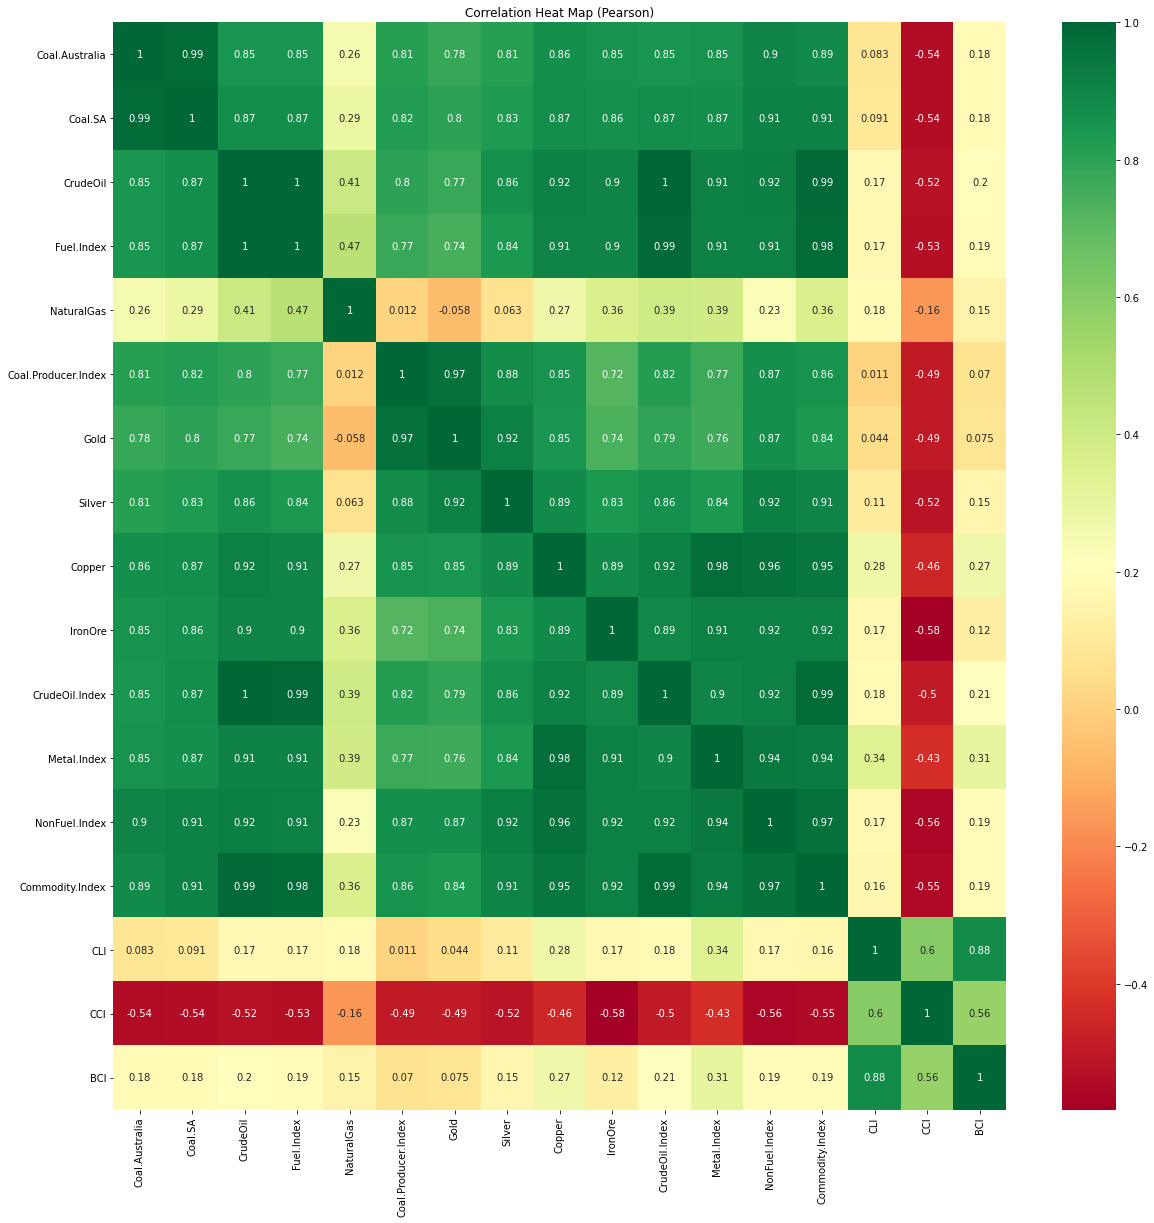

In [9]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn").set_title("Correlation Heat Map (Pearson)")

### Spearman Correlation Coefficient

In [10]:
df.corr(method='spearman')

,Coal.Australia,Coal.SA,CrudeOil,Fuel.Index,NaturalGas,Coal.Producer.Index,Gold,Silver,Copper,IronOre,CrudeOil.Index,Metal.Index,NonFuel.Index,Commodity.Index,CLI,CCI,BCI
Coal.Australia,1.000000,0.973604,0.825700,0.820585,0.292782,0.852715,0.867391,0.849249,0.908248,0.863539,0.824017,0.886046,0.917062,0.873373,0.197288,-0.477537,0.276444
Coal.SA,0.973604,1.000000,0.855360,0.850857,0.366861,0.858414,0.867964,0.857961,0.893044,0.865173,0.855584,0.885854,0.904266,0.905722,0.195795,-0.466701,0.286296
CrudeOil,0.825700,0.855360,1.000000,0.992517,0.585672,0.835841,0.783084,0.826411,0.879207,0.899158,0.997040,0.897172,0.851992,0.977501,0.255747,-0.480276,0.272766
Fuel.Index,0.820585,0.850857,0.992517,1.000000,0.623822,0.820430,0.767719,0.813453,0.872256,0.894594,0.987847,0.892057,0.846298,0.972673,0.253454,-0.484887,0.269419
NaturalGas,0.292782,0.366861,0.585672,0.623822,1.000000,0.233309,0.148604,0.258498,0.354649,0.461426,0.566852,0.449583,0.288322,0.541609,0.266691,-0.137696,0.271374
Coal.Producer.Index,0.852715,0.858414,0.835841,0.820430,0.233309,1.000000,0.931889,0.861441,0.834572,0.837785,0.844469,0.790692,0.852627,0.853923,0.093087,-0.540761,0.184543
Gold,0.867391,0.867964,0.783084,0.767719,0.148604,0.931889,1.000000,0.918048,0.873463,0.811249,0.783456,0.826023,0.899988,0.842226,0.138960,-0.528130,0.185918
Silver,0.849249,0.857961,0.826411,0.813453,0.258498,0.861441,0.918048,1.000000,0.872711,0.825872,0.826732,0.857810,0.911157,0.872452,0.275775,-0.411287,0.284948
Copper,0.908248,0.893044,0.879207,0.872256,0.354649,0.834572,0.873463,0.872711,1.000000,0.877198,0.869944,0.978305,0.958723,0.921424,0.336280,-0.465062,0.352826
IronOre,0.863539,0.865173,0.899158,0.894594,0.461426,0.837785,0.811249,0.825872,0.877198,1.000000,0.896075,0.888762,0.875642,0.903172,0.166245,-0.558628,0.168960


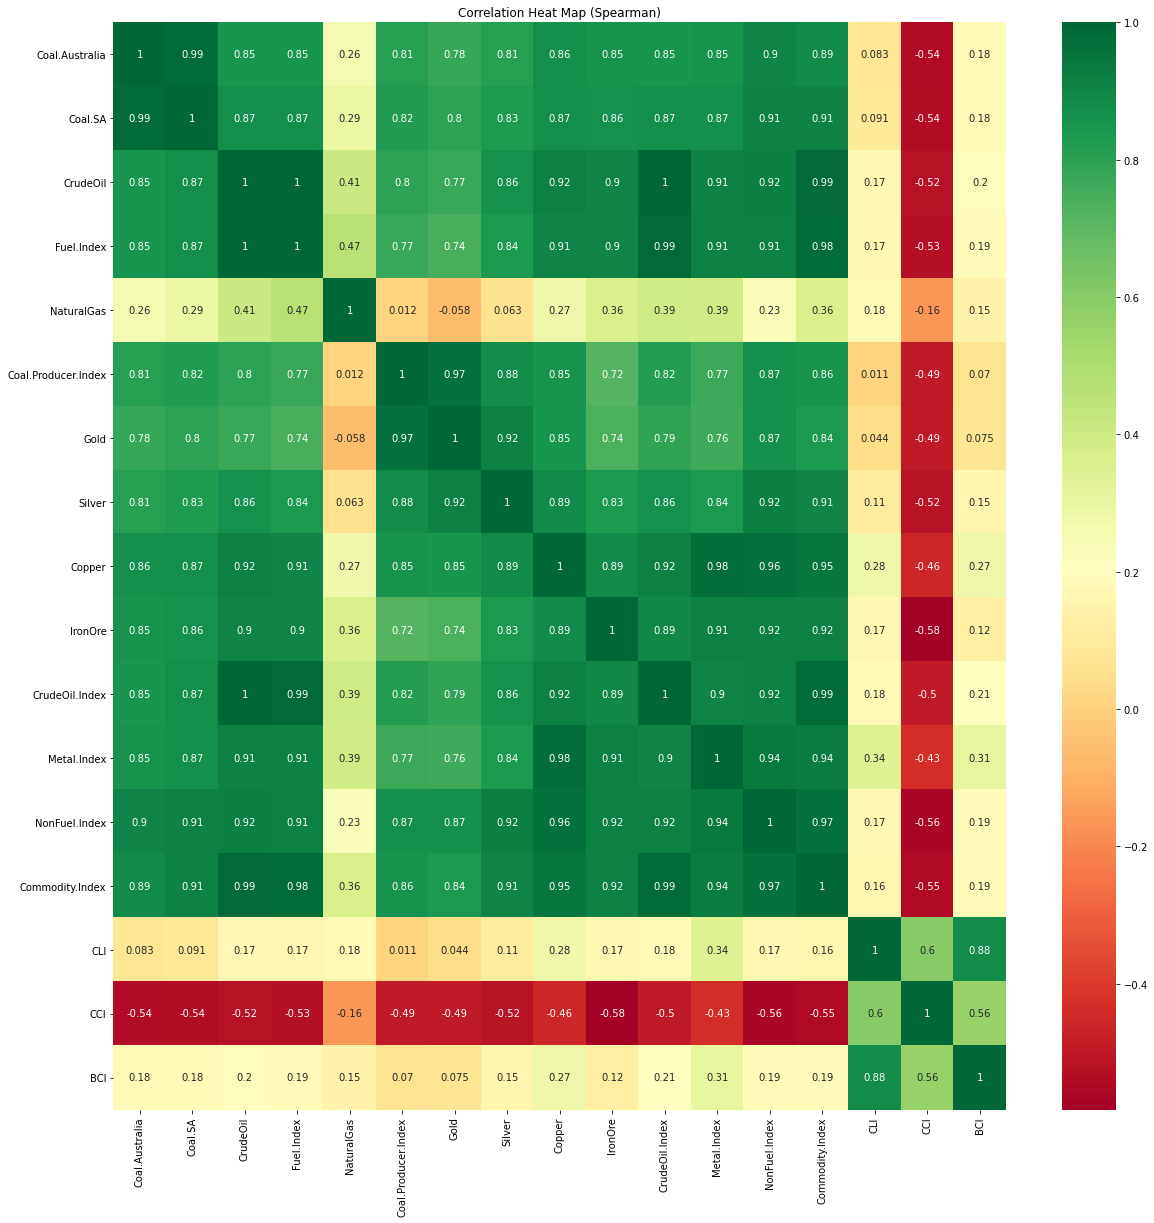

In [11]:
corrmat_spearman = df.corr(method='spearman')
top_corr_features = corrmat_spearman.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn").set_title("Correlation Heat Map (Spearman)")

As we can see, there is no big difference that needs to be considered between two different correlation coefficients. Therefore, we will continue with our feature selection step using Pearson Correlation Coefficient.

### Feature Selection

We will look at the features that have higher correlation than 0.5 with our target variable.

In [12]:
#Correlation with output variable
cor_target = abs(corrmat["Coal.SA"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
print(relevant_features)

Coal.Australia         0.987597
Coal.SA                1.000000
CrudeOil               0.871322
Fuel.Index             0.873123
Coal.Producer.Index    0.823938
Gold                   0.801117
Silver                 0.829874
Copper                 0.874786
IronOre                0.862946
CrudeOil.Index         0.870686
Metal.Index            0.865686
NonFuel.Index          0.910450
Commodity.Index        0.907782
CCI                    0.539615
Name: Coal.SA, dtype: float64


Now, we will check the correlation between these variables. The reason why we need check the correlation between the attributes besides our target attribute, is to find the unnecessary ones. These unnecessary attributes will cause us problems such as overfitting during the machine learning step. Thus, we have to detect them and remove them from our data

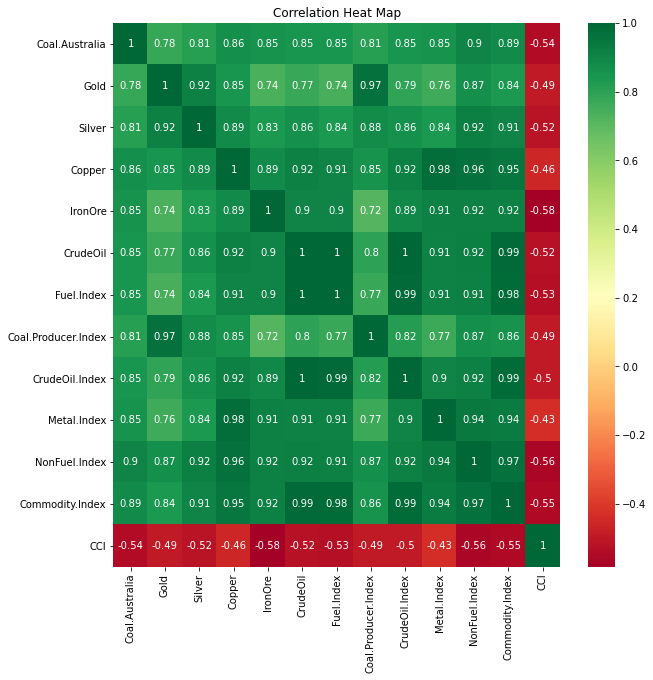

In [13]:
rf_df = df[['Coal.Australia', 'Gold','Silver','Copper','IronOre','CrudeOil','Fuel.Index','Coal.Producer.Index','CrudeOil.Index','Metal.Index','NonFuel.Index','Commodity.Index','CCI']]
fig, ax = plt.subplots(figsize=(10,10))
h=sns.heatmap(rf_df.corr(),annot=True,cmap="RdYlGn",ax=ax).set_title("Correlation Heat Map")

## Notes about correlation

From the above correlation matrix, we get the following results
    * Gold and Copper has high correlation
    * Gold and Coal.Producer.Index has high correlation
    * Silver and Gold has high Correlation
    * Silver and NonFuel.Index has high correlation also there is high correlation with Commodity.Index
    * Copper and CrudeOil,Fuel.Index,Metal.Index,NonFuel.Index,Commodity.Index and CrudeOil.Index has    high correlation
    * IronOre and Fuel.Index,CrudeOil,Metal.Index,NonFuel.Index,Commodity.Index has high correlation
    * CrudeOil and Metal.Index,NonFuel.Index,Commodity.Index has high correlation
    * CrudeOil.Index and Fuel.Index,NonFuel.Index,Metal.Index has high correlation
    * Metal.Index has high correlation with Fuel.Index,NonFuel.Index,Commodity.Index
    * NonFuel.Index has high correlation with Fuel.Index,Commodity.Index
    
 We will check these variables' correlation with our target variable and then drop the  attribute that has lowest correlation with our target. If two attribute has a high correlation between them, this means that they almost have linear relationship. So, we can think of them as a single variable basically. Therefore, we will see which one has the highest correlation with our target variable and remove the other one.

Text(0.5, 1.0, 'Metal.Index vs. Copper')

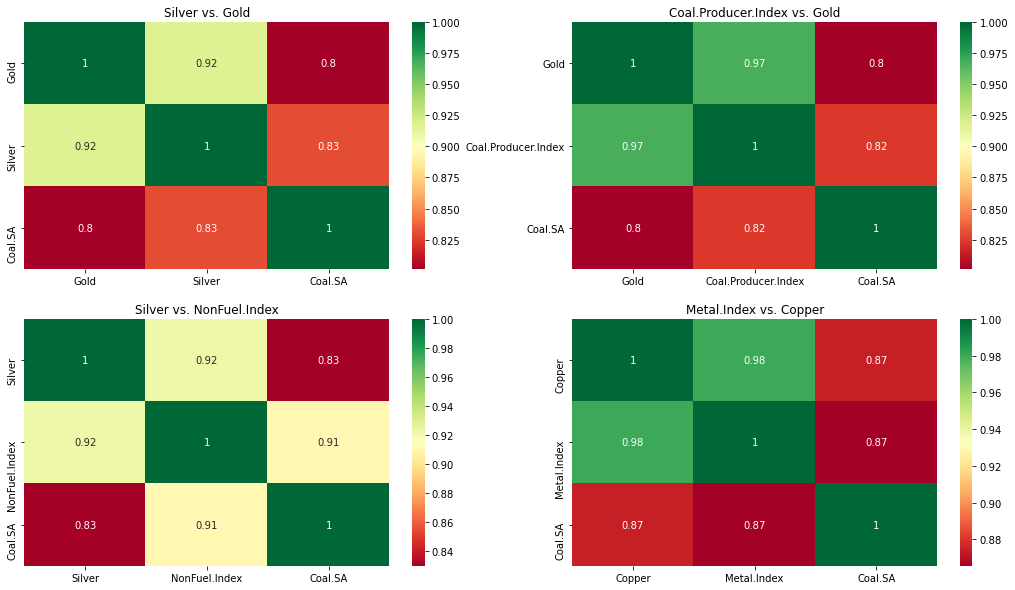

In [14]:
fig2,ax2 = plt.subplots(2,2)
sns.heatmap(df[['Gold','Silver','Coal.SA']].corr(),ax=ax2[0][0],annot=True,cmap="RdYlGn").set_title('Silver vs. Gold')
sns.heatmap(df[['Gold','Coal.Producer.Index','Coal.SA']].corr(),ax=ax2[0][1],annot=True,cmap="RdYlGn").set_title('Coal.Producer.Index vs. Gold')
sns.heatmap(df[['Silver','NonFuel.Index','Coal.SA']].corr(),ax=ax2[1][0],annot=True,cmap="RdYlGn").set_title('Silver vs. NonFuel.Index')
sns.heatmap(df[['Copper','Metal.Index','Coal.SA']].corr(),ax=ax2[1][1],annot=True,cmap="RdYlGn").set_title('Metal.Index vs. Copper')


We examined the attributes that has high correlation between them and observed their relationship with our target variable. After analysing the heatmaps above, we decided to drop "Gold, and Silver" attributes.

Text(0.5, 1.0, 'Fuel.Index vs. CrudeOil')

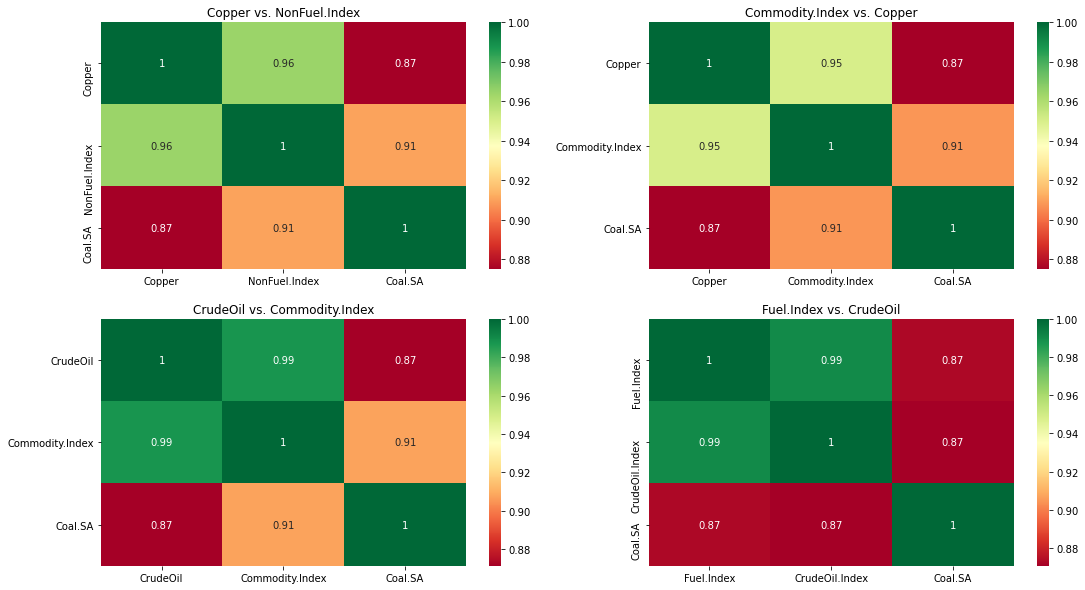

In [15]:
fig3,ax3 = plt.subplots(2,2)
sns.heatmap(df[['Copper','NonFuel.Index','Coal.SA']].corr(),ax=ax3[0][0],annot=True,cmap="RdYlGn").set_title('Copper vs. NonFuel.Index')
sns.heatmap(df[['Copper','Commodity.Index','Coal.SA']].corr(),ax=ax3[0][1],annot=True,cmap="RdYlGn").set_title('Commodity.Index vs. Copper')
sns.heatmap(df[['CrudeOil','Commodity.Index','Coal.SA']].corr(),ax=ax3[1][0],annot=True,cmap="RdYlGn").set_title('CrudeOil vs. Commodity.Index')
sns.heatmap(df[['Fuel.Index','CrudeOil.Index','Coal.SA']].corr(),ax=ax3[1][1],annot=True,cmap="RdYlGn").set_title('Fuel.Index vs. CrudeOil') 

After analysing the heatmaps above, we decided to drop "Gold, and Silver" attributes. We decide to take the attribute "Non-Fuel" and drop "Copper".

Text(0.5, 1.0, 'CrudeOil.Index vs. Commodity.Index')

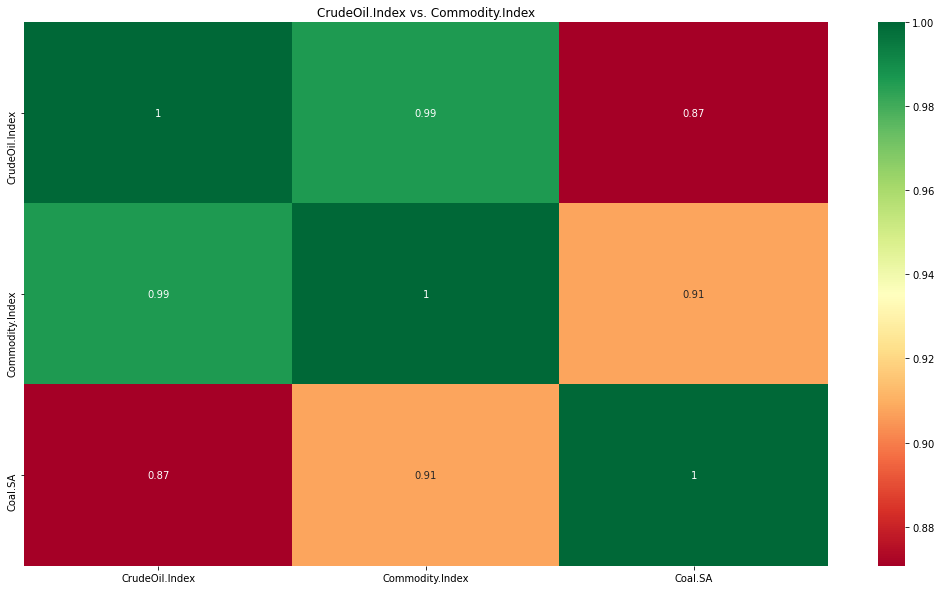

In [16]:
sns.heatmap(df[['CrudeOil.Index','Commodity.Index','Coal.SA']].corr(),annot=True,cmap="RdYlGn").set_title("CrudeOil.Index vs. Commodity.Index") 


We will take all the variables has high correlation with our target "Corel.SA" and drop the others with the ones we decide to eliminate after analysing the heatmaps above.


In [17]:
df.drop(['Gold','Silver','Copper','CrudeOil','CLI','BCI','NaturalGas'], axis=1,inplace=True)
df.head()
df.shape

(343, 10)

In [18]:
df.columns

Index(['Coal.Australia', 'Coal.SA', 'Fuel.Index', 'Coal.Producer.Index',
       'IronOre', 'CrudeOil.Index', 'Metal.Index', 'NonFuel.Index',
       'Commodity.Index', 'CCI'],
      dtype='object')

# Exploratory Data Analysis

Questions to be answered:

    1) Are there consistent patterns? 

    2) Is there a significant trend? 

    3) Is there seasonality?

    4) Is there evidence of the presence of cycles? 

    5) Are there any outliers in the data that need to be explained by those with expert knowledge? 

    6) How strong are the relationships among the variables available for analysis?


EDA: Plotting "trend". Visualize and check seasonality trend of our time series.



### Time Series Plot

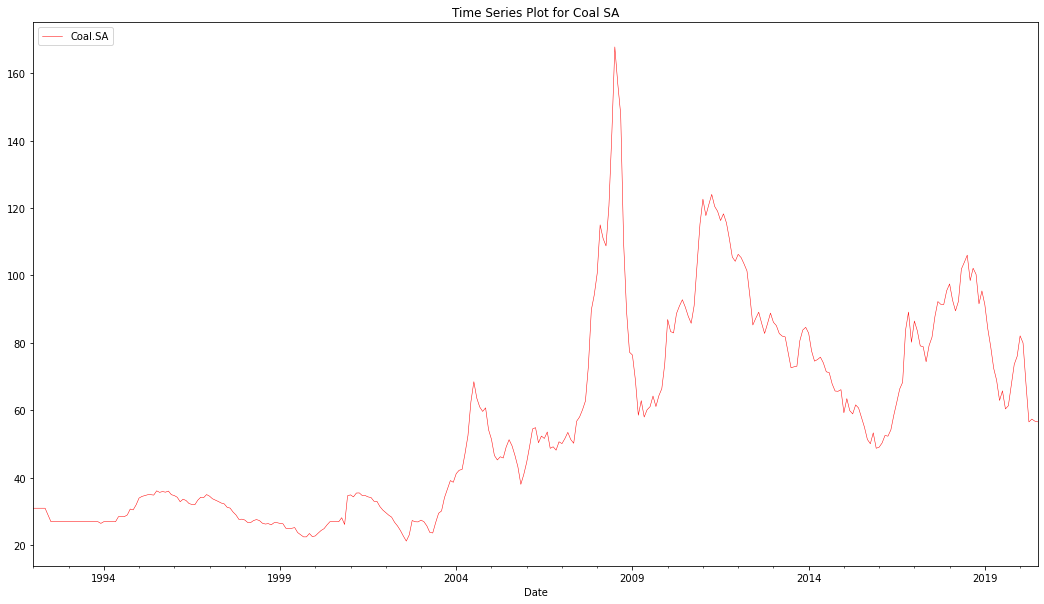

In [19]:
df["Coal.SA"].plot(linewidth=0.5, color='red')
plt.legend(df[["Coal.SA"]], loc ="upper left") 
plt.title("Time Series Plot for Coal SA")
plt.show()

Time series plot reveals that the coal prices have generally increased over time. There is a clear sign of trend. The variance seems to be low from 1992-2002 and is higher generally higher 2004 onwards. This indicates that in order to account for this increase in variance, we may need to take the log of the series. There are no cycles in the series. 
   

## Trend

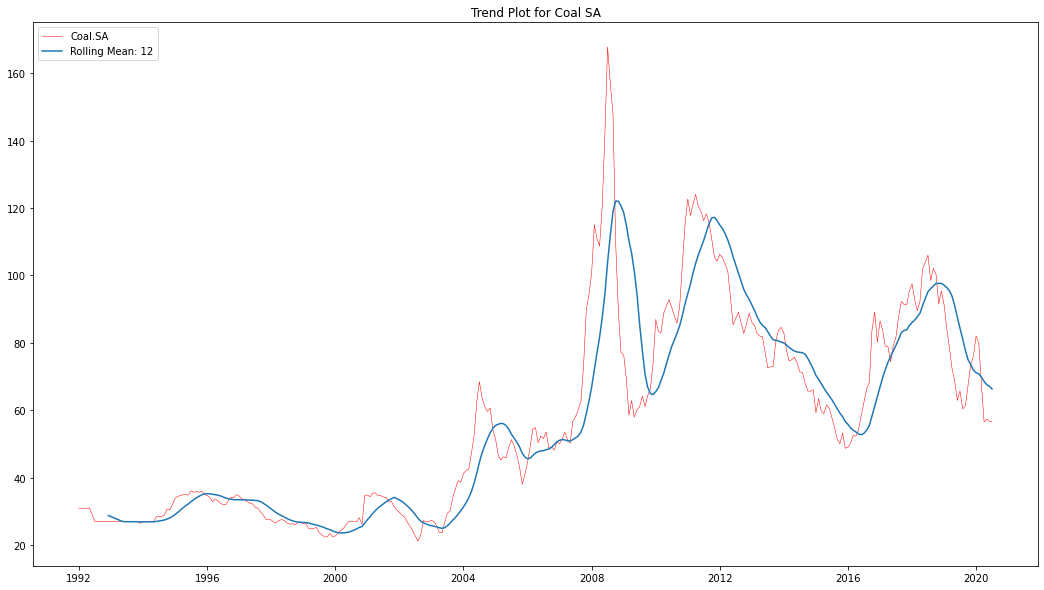

In [20]:
plt.plot(df.index, df["Coal.SA"], linewidth=0.5, color='red')
plt.plot(pd.Series.rolling(df["Coal.SA"], 12).mean())
plt.legend(["Coal.SA", "Rolling Mean: 12"], loc ="upper left") 
plt.title("Trend Plot for Coal SA")
plt.show()

The simple moving average is the unweighted mean of the previous M data points. Here M=12 to account for the annual effect.
We can see that:
1) Coal SA series has a trend. It goes up until around 2008 and then the trend changes direction and starting from 2008. Since there is trend, the time series is not stationary.

Because of the trend, we may say that the data is not stationary but such a hypothesis needs to be checked using the following methods: (ACF plot of the data as well as the Adjusted Dickey Fuller Test)

## Seasonality

In [21]:
df['Year'] = pd.DatetimeIndex(df.index).year
df['Month'] = pd.DatetimeIndex(df.index).month

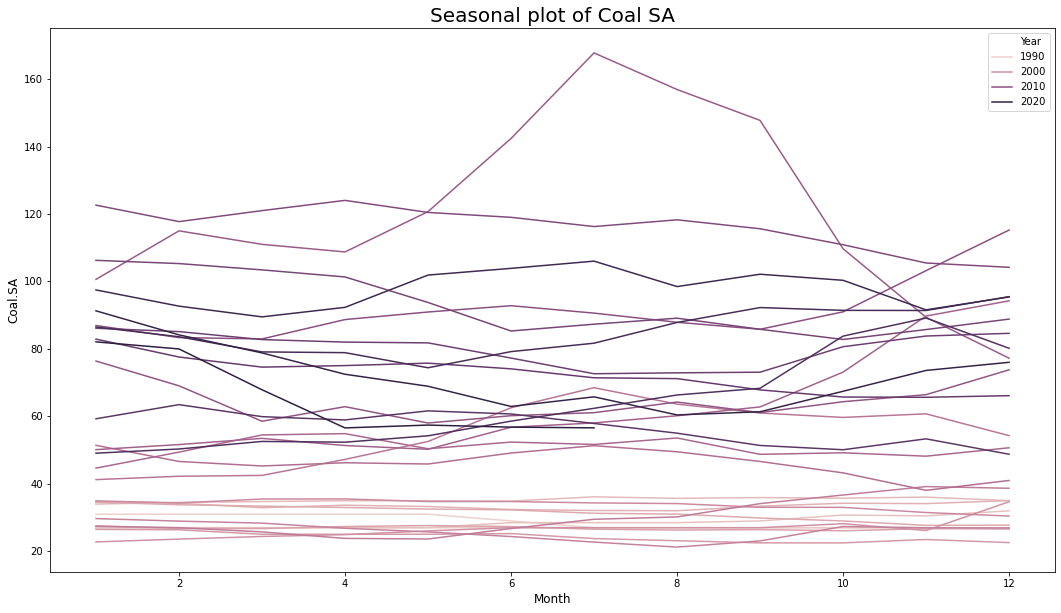

In [22]:
fig, ax = plt.subplots()
ax.set_xlabel('Month', fontsize = 12)
ax.set_ylabel('Seasonal Plot for Coal SA Price', fontsize = 12);
ax.set_title('Seasonal plot of Coal SA', fontsize = 20, loc='center');
sns.lineplot(x=df['Month'], y=df["Coal.SA"], hue=df['Year']);

Looking at the seasonal plot, there does not seem to be a significant increase or decrease from one month to another over the years, although in the obvious outlier, there seems to be an increase from April to July. However, the general picture reflects no "obvious" seasonality.

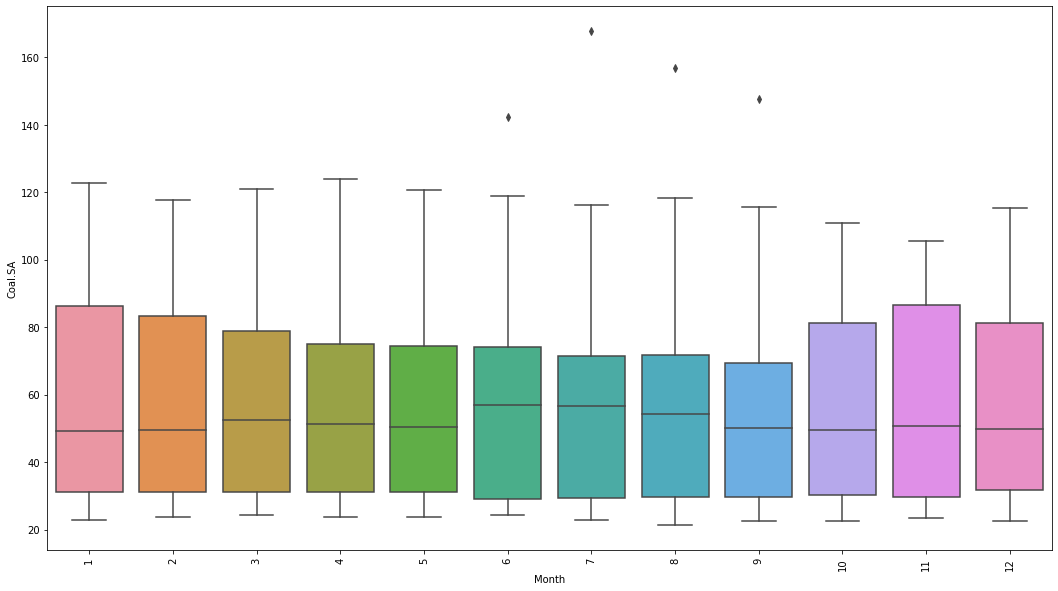

In [23]:
ax = sns.boxplot(data=df, x='Month', y='Coal.SA')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

As it can be seen from the seasonal boxplot, the overall level of all months are around the same, therefore we can again conclude there is no obvious seasonality. We also realize there are some outliers, looking back at the data for those levels, it indicates that the outliers are coming from the year 2008-2009.

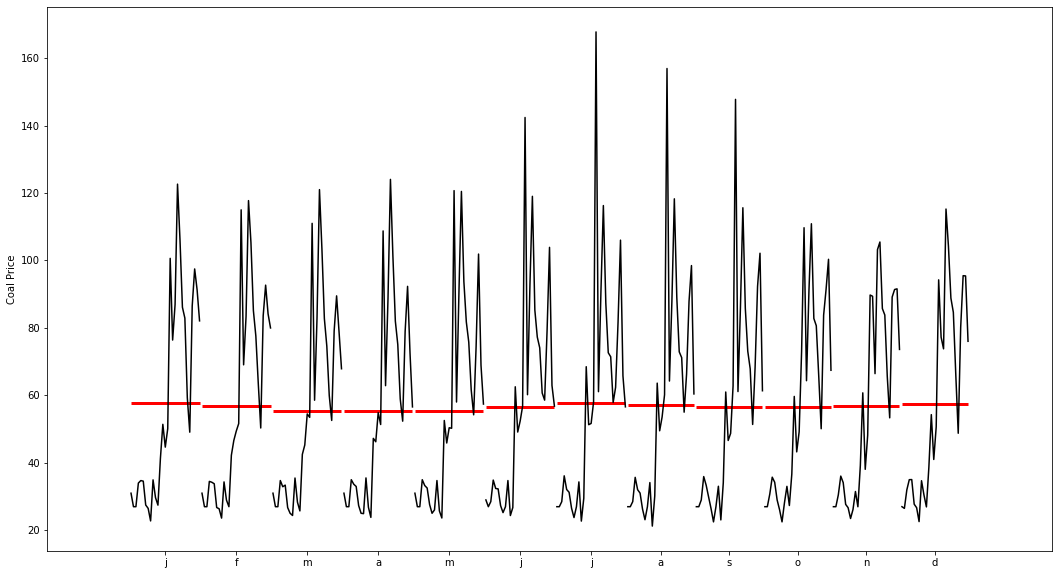

In [24]:
month_plot(df["Coal.SA"],ylabel='Coal Price');

As it can be seen from the seasonal subseries plot, the overall level of all months are around the same, therefore we can again conclude there is no obvious seasonality.

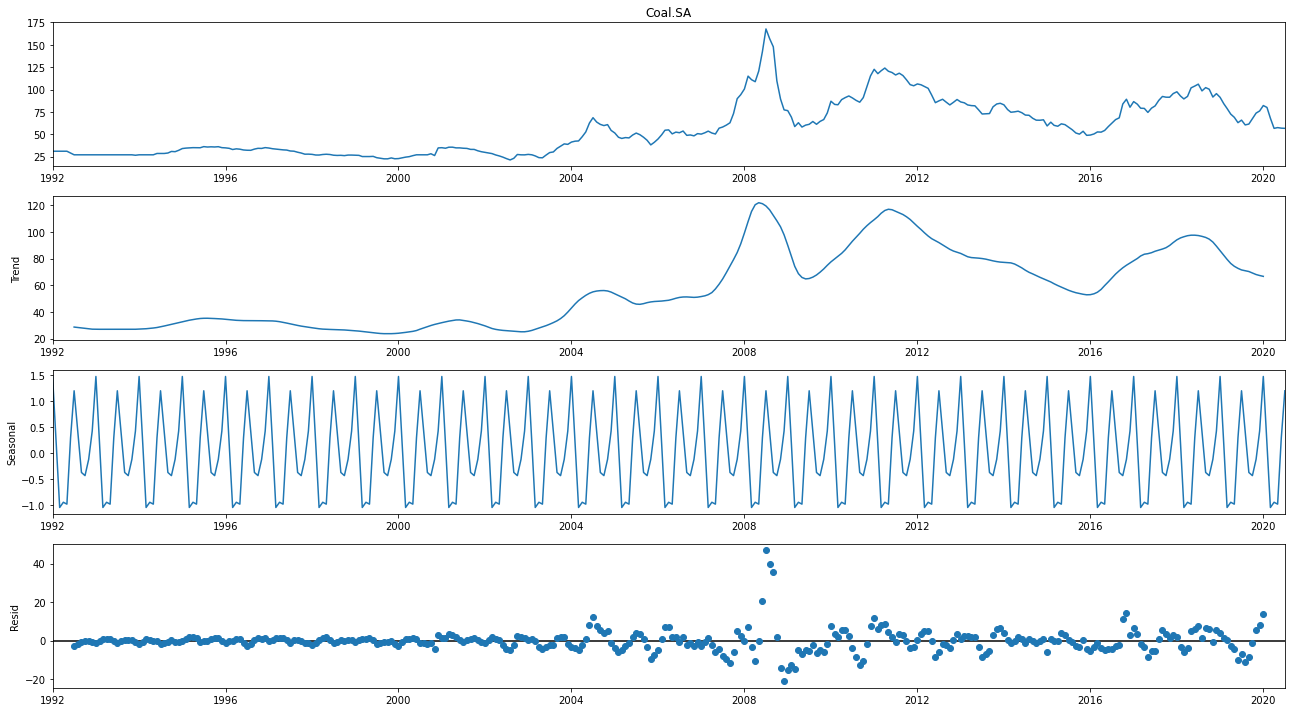

In [25]:
cls_decomposition = sm.tsa.seasonal_decompose(df["Coal.SA"], model='additive')
fig = cls_decomposition.plot()
plt.show()

From the classical decomposition, we can conclude that there appears to be no significant seasonality in the data since the seasonal component ranges from -1 to 1 (in the additive case does not have significant influence). We can see how little seasonality plays a role by plotting the seasonally adjusted and the original data together.

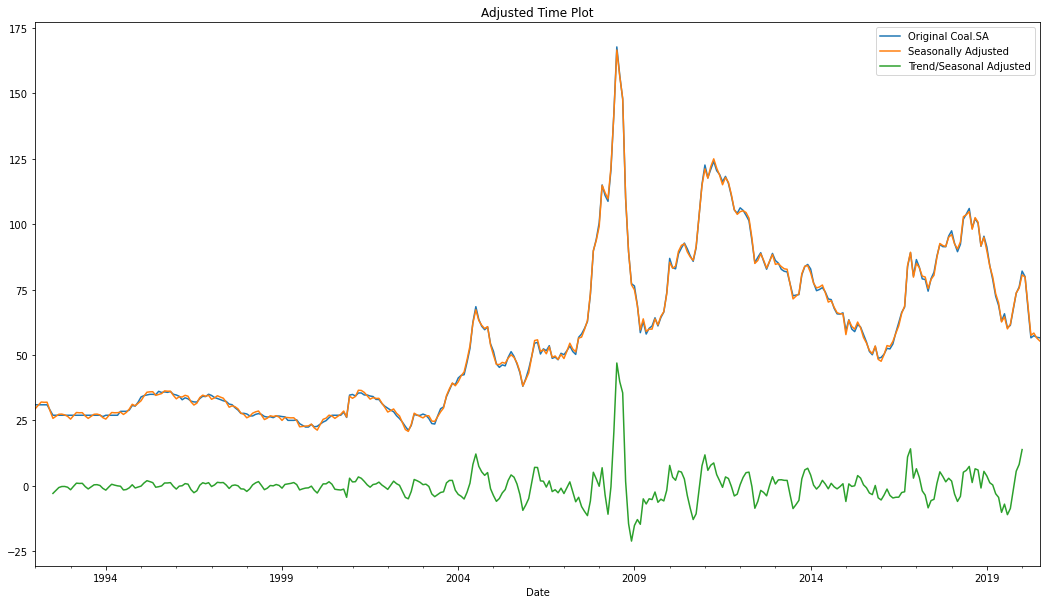

In [26]:
df["Coal.SA"].plot(label="Original Coal.SA")
df['Seasonally Adjusted'] = df['Coal.SA'] - cls_decomposition.seasonal
df["Seasonally Adjusted"].plot(label="Seasonally Adjusted")
df["Trend/Seasonal Adjusted"] = df["Coal.SA"] - cls_decomposition.seasonal- cls_decomposition.trend
df["Trend/Seasonal Adjusted"].plot(label="Trend/Seasonal Adjusted")
plt.legend();
plt.title("Adjusted Time Plot");

Here we can see that seasonality does not have a significant effect whereas the trend does.

## Handling Outliers


For every attribute we will check if there are any outliers by using box plots. We will examine the data both from years and months perspective. Since we do not have too much data, we will replace the outliers with the mean of the corresponding attribute.

### Checking Outliers (Month Perspective)


Text(0.5, 1.0, 'Coal.Producer.Index')

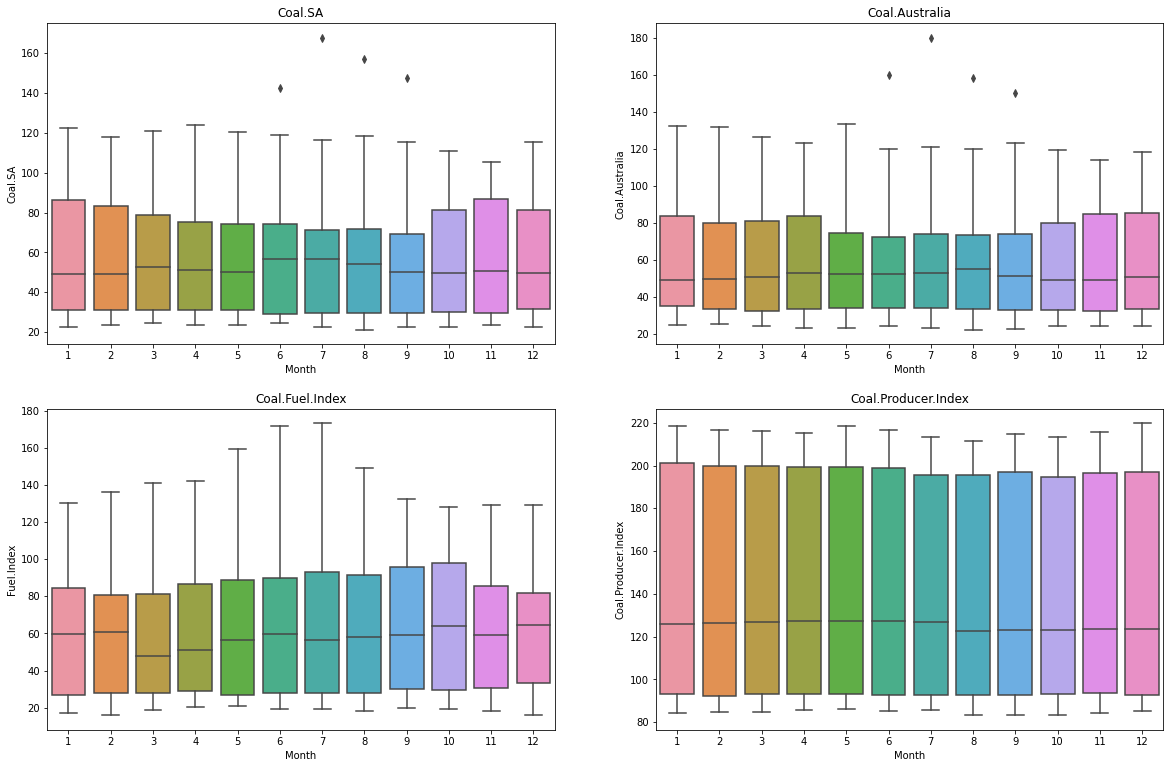

In [27]:
fig3,ax3 = plt.subplots(2,2,figsize=(20,13))
sns.boxplot(data=df, x='Month', y='Coal.SA',ax=ax3[0][0]).set_title("Coal.SA")
sns.boxplot(data=df, x='Month', y='Coal.Australia',ax=ax3[0][1]).set_title("Coal.Australia")
sns.boxplot(data=df, x='Month', y='Fuel.Index',ax=ax3[1][0]).set_title("Coal.Fuel.Index")
sns.boxplot(data=df, x='Month', y='Coal.Producer.Index',ax=ax3[1][1]).set_title("Coal.Producer.Index")

As we can see from the box-plots above we have outliers in our attributes Coal.SA and Coal.Australia.

Text(0.5, 1.0, 'Commodity.Index')

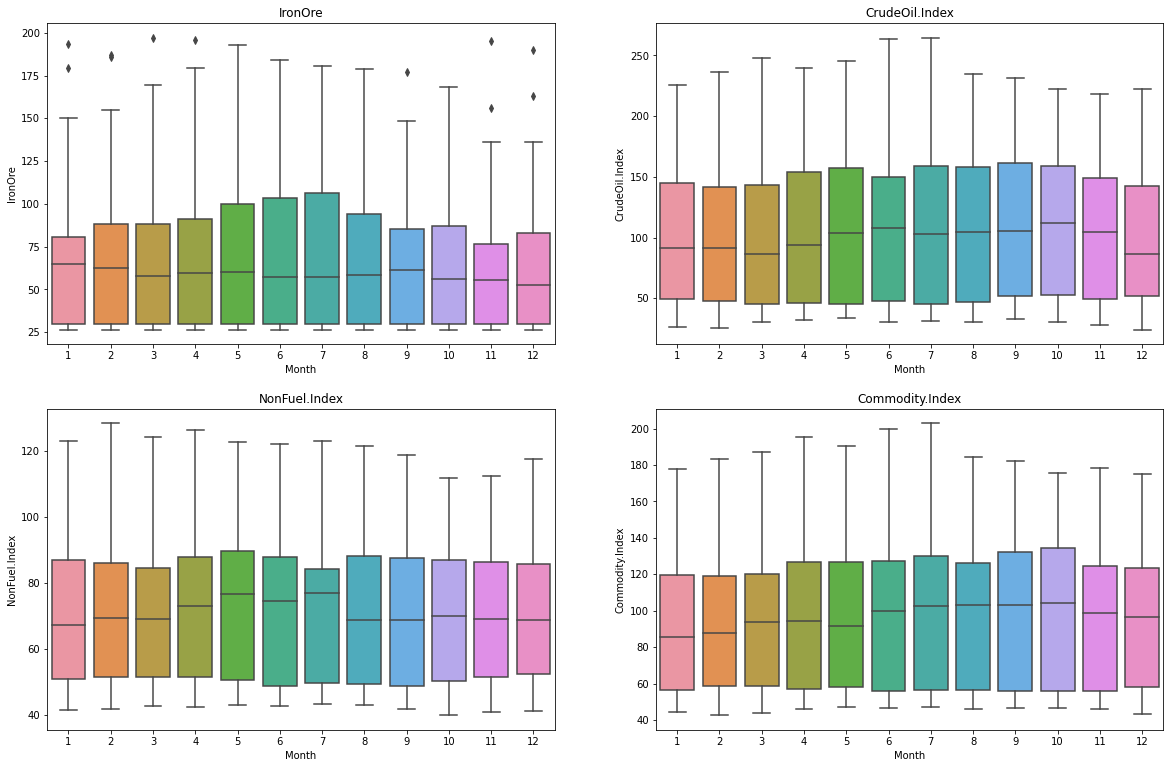

In [28]:
fig3,ax3 = plt.subplots(2,2,figsize=(20,13))
sns.boxplot(data=df, x='Month', y='IronOre',ax=ax3[0][0]).set_title("IronOre")
sns.boxplot(data=df, x='Month', y='CrudeOil.Index',ax=ax3[0][1]).set_title("CrudeOil.Index")
sns.boxplot(data=df, x='Month', y='NonFuel.Index',ax=ax3[1][0]).set_title("NonFuel.Index")
sns.boxplot(data=df, x='Month', y='Commodity.Index',ax=ax3[1][1]).set_title("Commodity.Index")

We can see that we have outliers in our attribute IronOre.

Text(0.5, 1.0, 'Metal.Index')

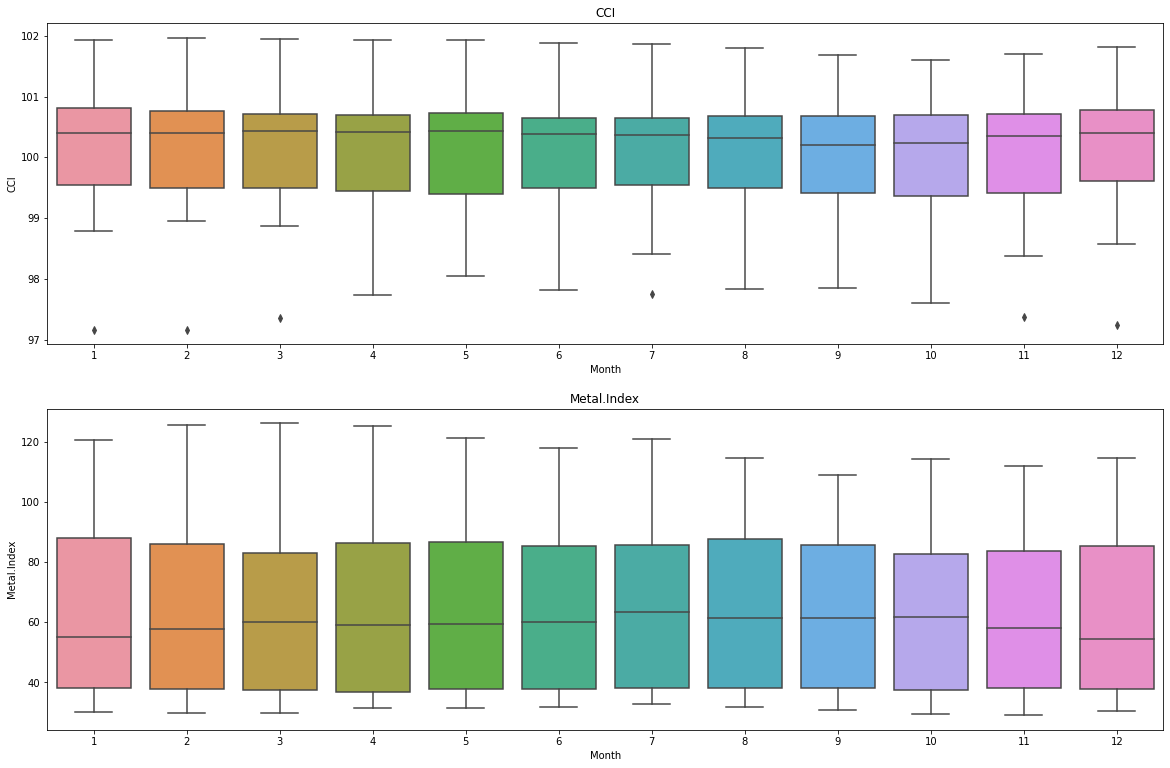

In [29]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Month',ax=ax3[0],y='CCI').set_title("CCI")
sns.boxplot(data=df, x='Month',ax=ax3[1],y='Metal.Index').set_title("Metal.Index")

Our attribute CCI also contains outliers.

### Replace the Outliers
As we can see, from month perspective,in some of the variables we have outliers. We will detect them using IQR score, and if they are below the lower whisker, we will assign lower_whisker + 1 to those values, and if they are above the upper whisker we will assign upper_whisker - 1. 

In [30]:
def calculate_whiskers(attribute,time,perspective):
    Q1=df.loc[df[perspective] == time, attribute].quantile(0.25)
    Q3=df.loc[df[perspective] == time, attribute].quantile(0.75)
    IQR=Q3-Q1
    Lower_Whisker = Q1 - 1.5*IQR
    Upper_Whisker = Q3 + 1.5*IQR
    return Upper_Whisker,Lower_Whisker

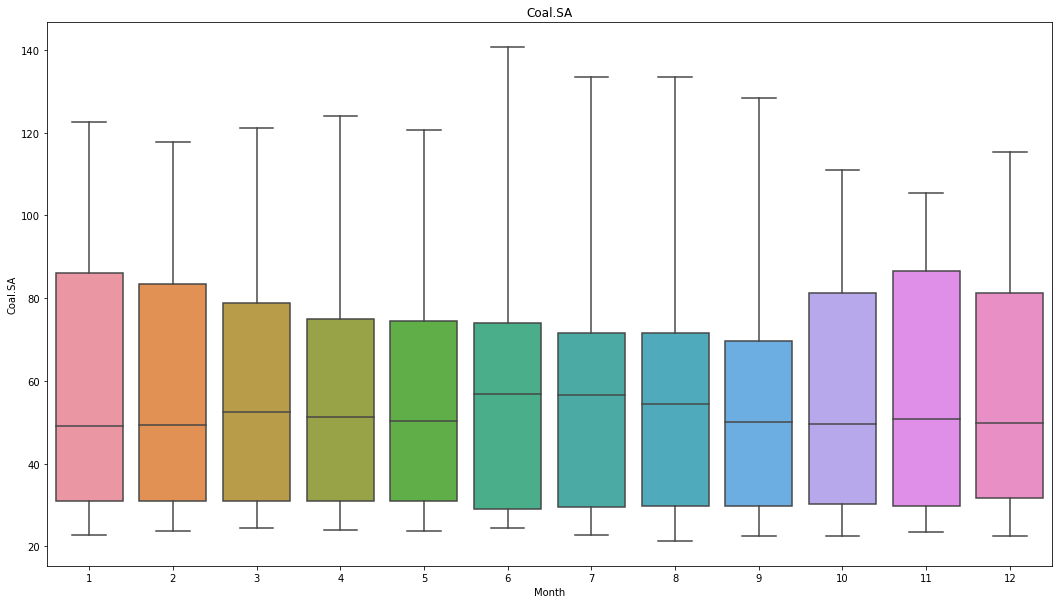

In [31]:
#For the target value "Coal.SA"
df.sort_values(by=['Coal.SA'],inplace=True)
months = [6,7,8,9]

for ind in df.index:
    for month in months:
        if (df['Month'][ind] == month): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Coal.SA",month,"Month")
            if(df['Coal.SA'][ind] > Upper_Whisker):
                df.replace(df['Coal.SA'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Coal.SA'][ind] < Lower_Whisker):
                df.replace(df['Coal.SA'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue      
ax = sns.boxplot(data=df, x='Month', y='Coal.SA').set_title("Coal.SA")

We successfully removed our attribute Coal.SA from the outliers!

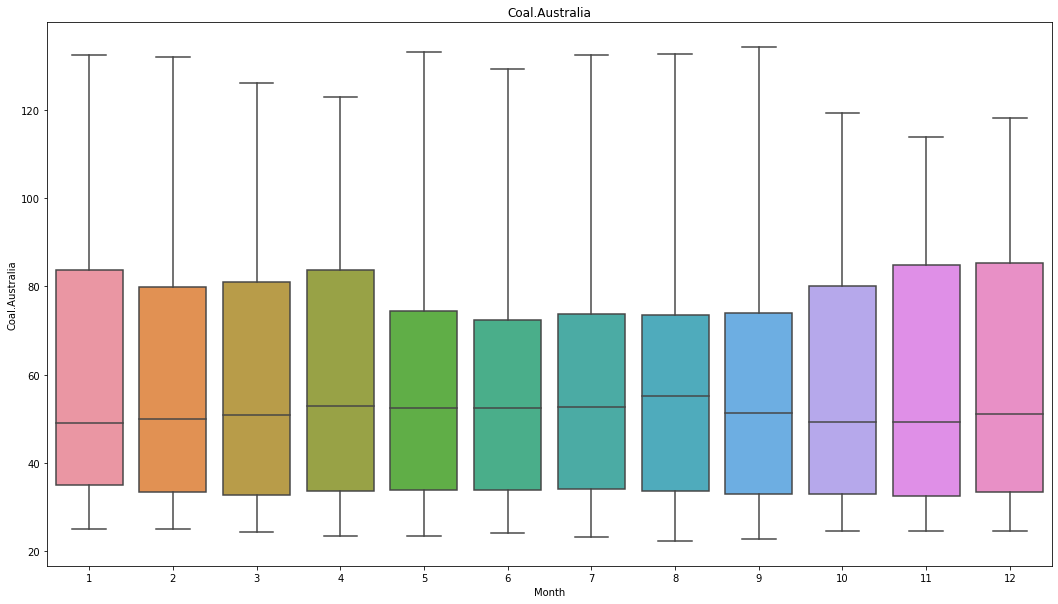

In [32]:
df.sort_values(by=['Coal.Australia'],inplace=True)

months = [6,7,8,9]

for ind in df.index:
    for month in months:
        if (df['Month'][ind] == month): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Coal.Australia",month,"Month")
            if(df['Coal.Australia'][ind] > Upper_Whisker):
                df.replace(df['Coal.Australia'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Coal.Australia'][ind] < Lower_Whisker):
                df.replace(df['Coal.Australia'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue  
                
ax = sns.boxplot(data=df, x='Month', y='Coal.Australia').set_title("Coal.Australia")

We successfully removed our attribute Coal.Australia from the outliers!

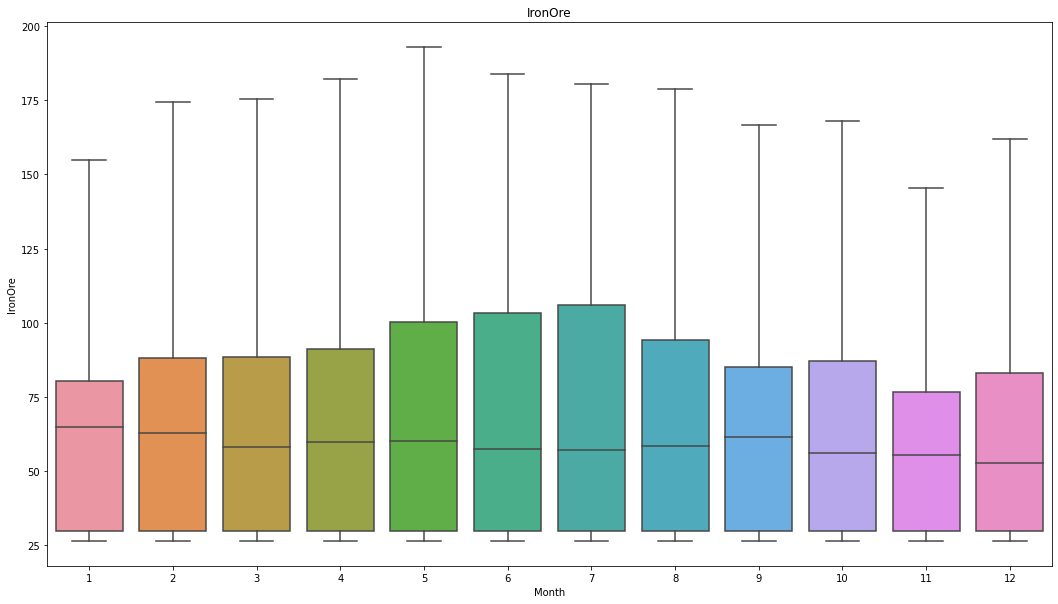

In [33]:
df.sort_values(by=['IronOre'],inplace=True)
months = [1,2,3,4,9,11,12]

for ind in df.index:
    for month in months:
        if (df['Month'][ind] == month): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("IronOre",month,"Month")
            if(df['IronOre'][ind] > Upper_Whisker):
                df.replace(df['IronOre'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['IronOre'][ind] < Lower_Whisker):
                df.replace(df['IronOre'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue  

ax = sns.boxplot(data=df, x='Month', y='IronOre').set_title("IronOre")

We successfully removed our attribute IronOre from the outliers!

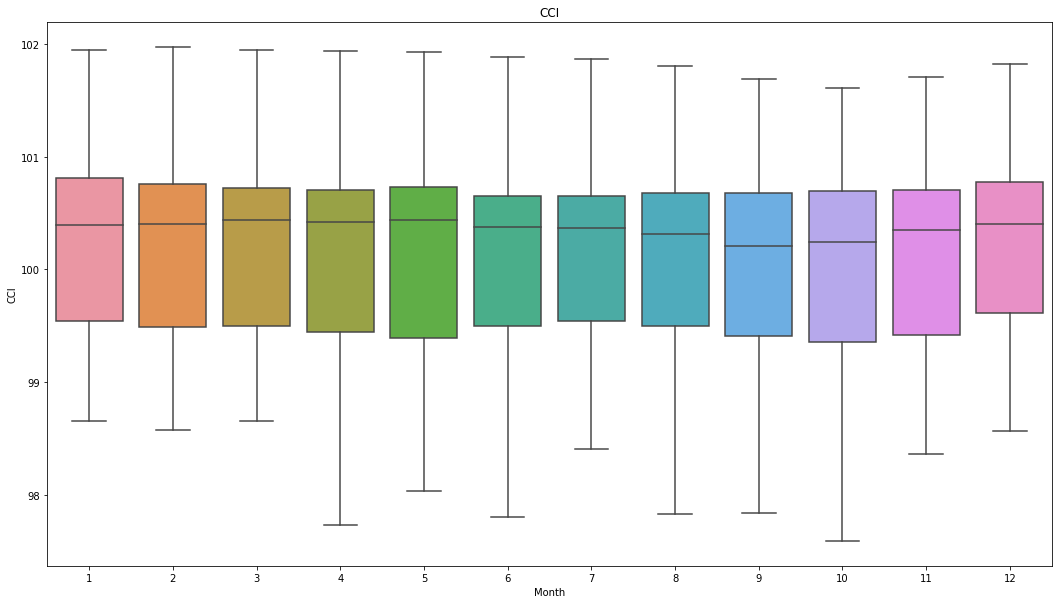

In [34]:
df.sort_values(by=['CCI'],inplace=True)

months = [1,2,3,7,11,12]

for ind in df.index:
    for month in months:
        if (df['Month'][ind] == month): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("CCI",month,"Month")
            if(df['CCI'][ind] > Upper_Whisker):
                df.replace(df['CCI'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['CCI'][ind] < Lower_Whisker):
                df.replace(df['CCI'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue  

ax = sns.boxplot(data=df, x='Month', y='CCI').set_title("CCI")            

As we can see, we removed the outliers.Our data looks outlier free!

In [ ]:
df.shape

## Checking Outliers (Year Perspective) 
Now we will look at the outliers from year perspective.

Text(0.5, 1.0, 'Coal.Australia')

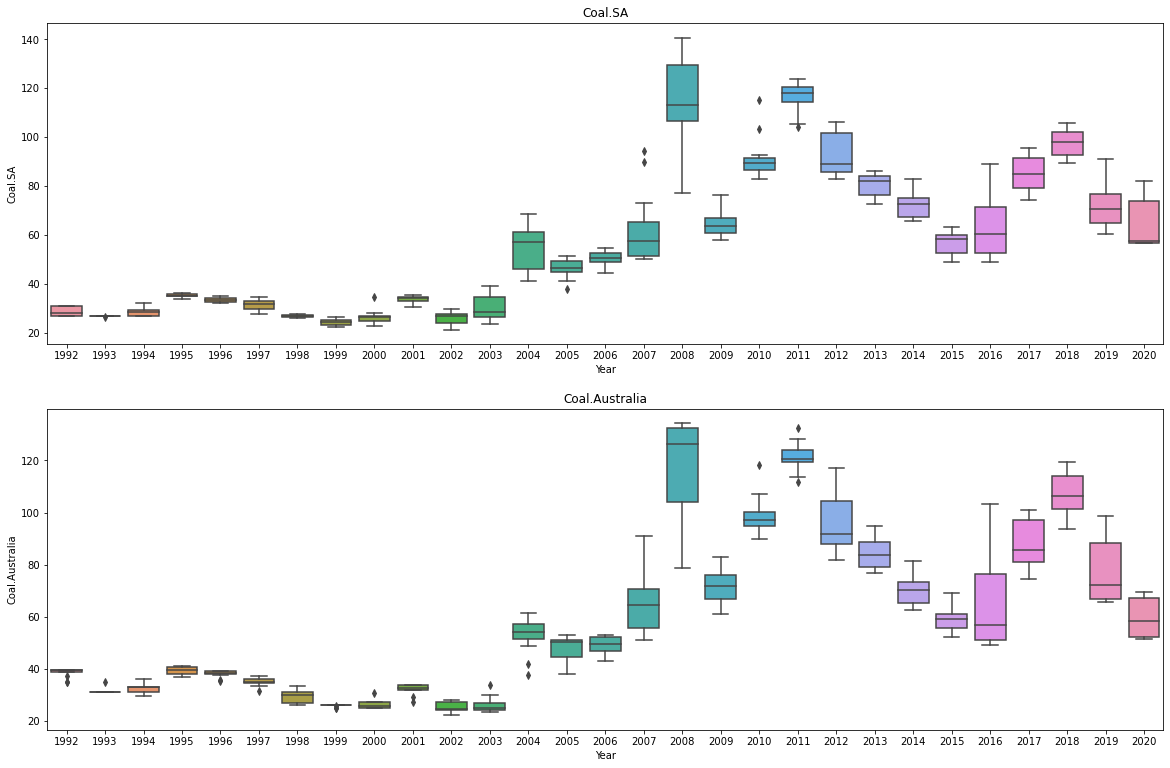

In [35]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='Coal.SA',ax=ax3[0]).set_title("Coal.SA")
sns.boxplot(data=df, x='Year', y='Coal.Australia',ax=ax3[1]).set_title("Coal.Australia")

Text(0.5, 1.0, 'Coal.Producer.Index')

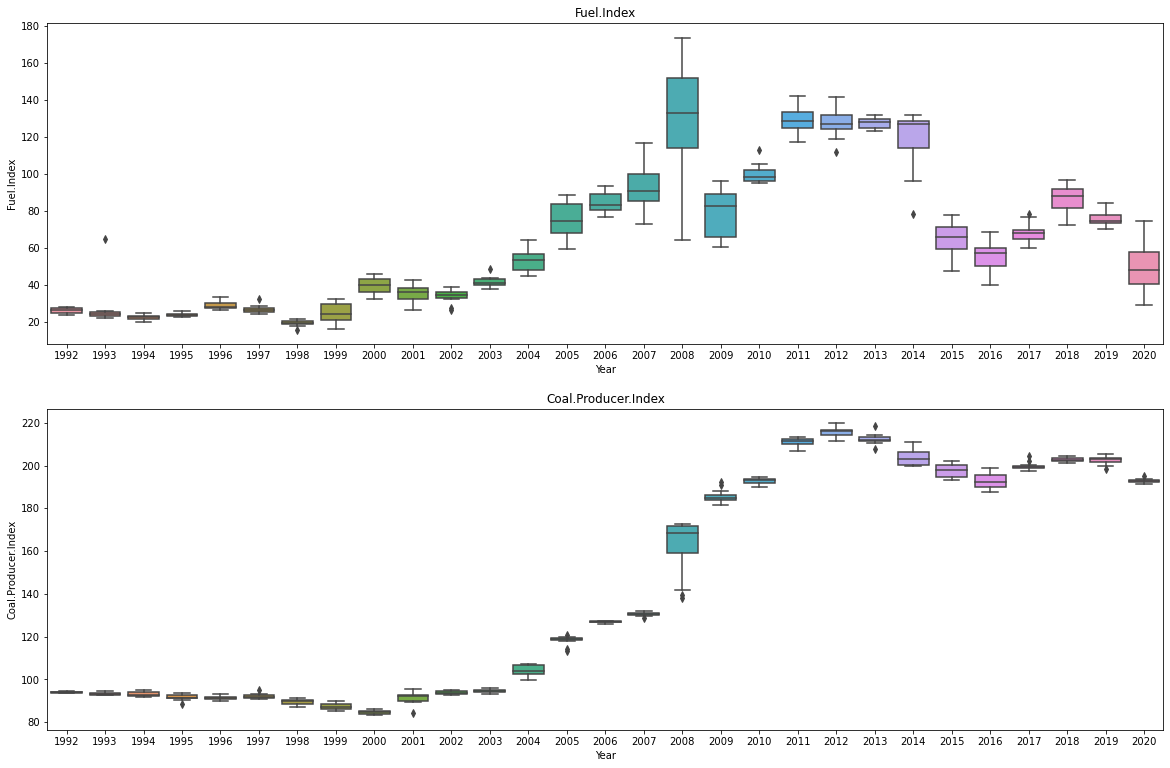

In [36]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='Fuel.Index',ax=ax3[0]).set_title("Fuel.Index")
sns.boxplot(data=df, x='Year', y='Coal.Producer.Index',ax=ax3[1]).set_title("Coal.Producer.Index")

Text(0.5, 1.0, 'CrudeOil.Index')

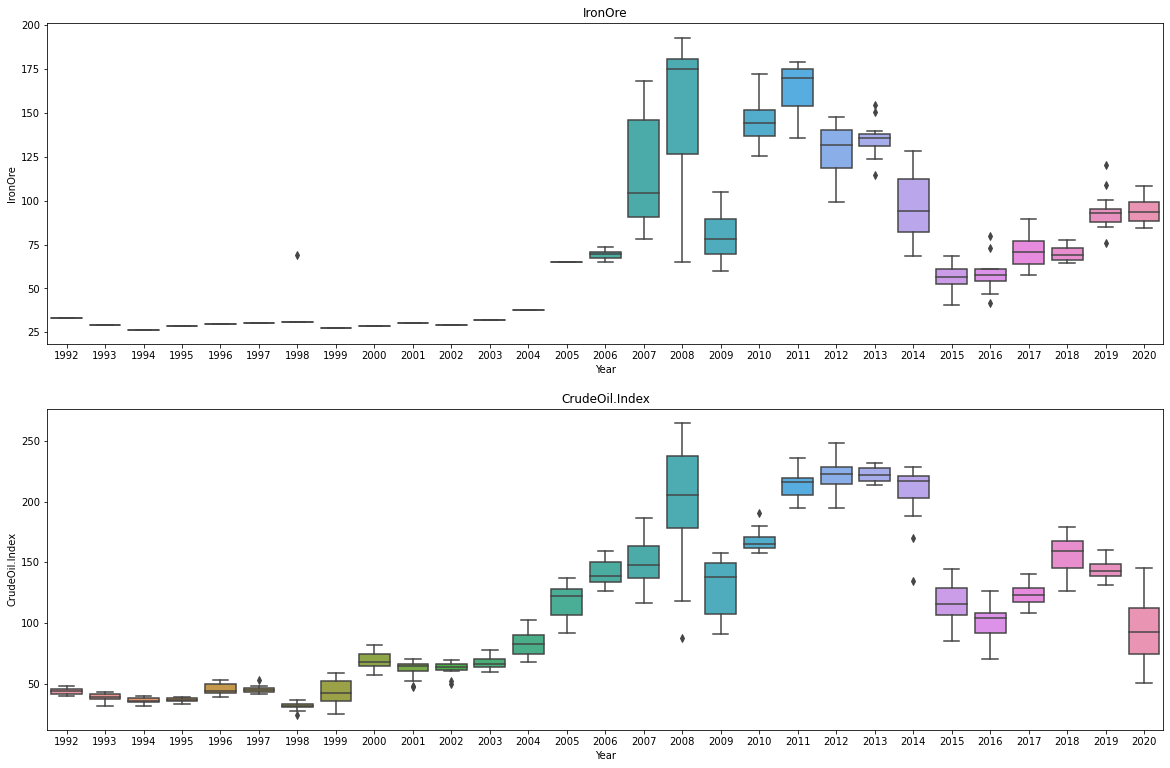

In [37]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='IronOre',ax=ax3[0]).set_title("IronOre")
sns.boxplot(data=df, x='Year', y='CrudeOil.Index',ax=ax3[1]).set_title("CrudeOil.Index")

Text(0.5, 1.0, 'Commodity.Index')

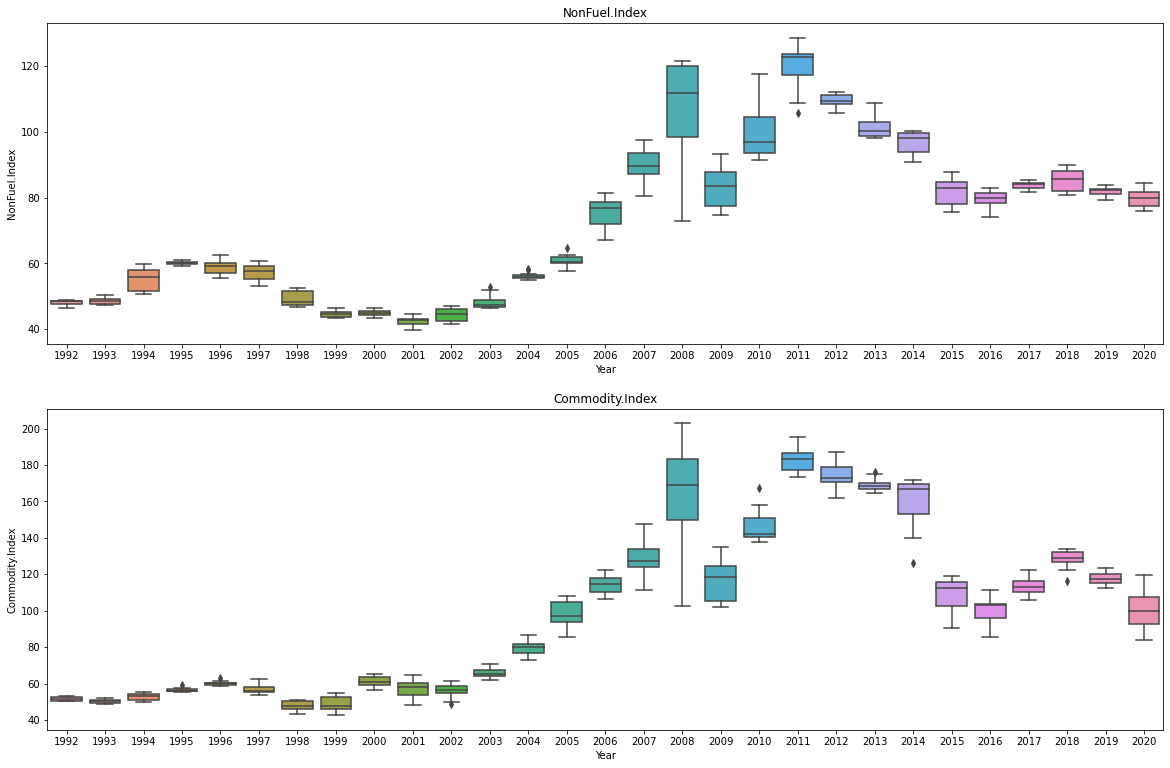

In [38]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='NonFuel.Index',ax=ax3[0]).set_title("NonFuel.Index")
sns.boxplot(data=df, x='Year', y='Commodity.Index',ax=ax3[1]).set_title("Commodity.Index")

Text(0.5, 1.0, 'Metal.Index')

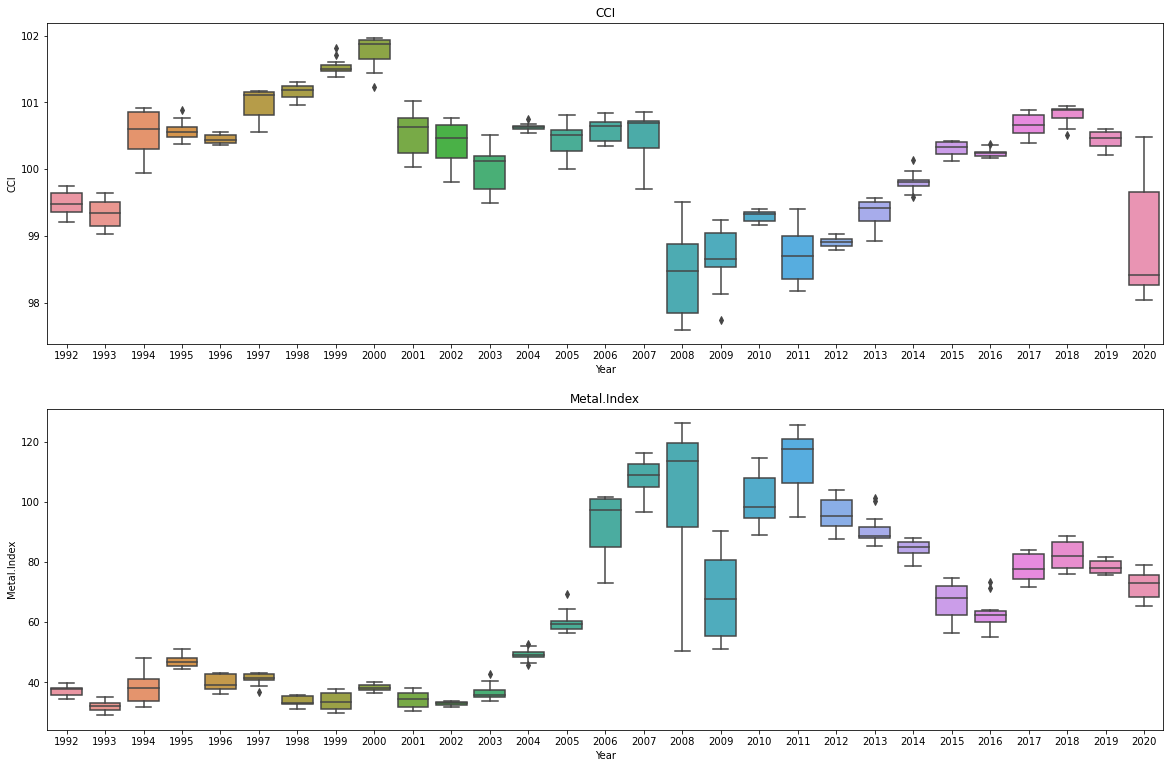

In [39]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year',ax=ax3[0],y='CCI').set_title("CCI")
sns.boxplot(data=df, x='Year',ax=ax3[1],y='Metal.Index').set_title("Metal.Index")

As we can see, from year perspective,in most of the attributes we have outliers. 

### Replacing the Outliers
We will detect outliers using IQR score. And if they are below the lower whisker, we will assign lower_whisker + 1 to those values, and if they are above the upper whisker we will assign upper_whisker - 1. 

In [40]:
#for Coal.SA
years = [1993,2000,2007,2010,2005,2011]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Coal.SA",year,"Year")
            if(df['Coal.SA'][ind] > Upper_Whisker):
                df.replace(df['Coal.SA'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Coal.SA'][ind] < Lower_Whisker):
                df.replace(df['Coal.SA'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

In [41]:
#For Coal.Aus
years = [1993,1992,1997,1999,1996,2001,2003,2004,2010,2000,2011]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Coal.Australia",year,"Year")
            if(df['Coal.Australia'][ind] > Upper_Whisker):
                df.replace(df['Coal.Australia'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Coal.Australia'][ind] < Lower_Whisker):
                df.replace(df['Coal.Australia'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

Text(0.5, 1.0, 'Coal.Australia after Outlier Removal')

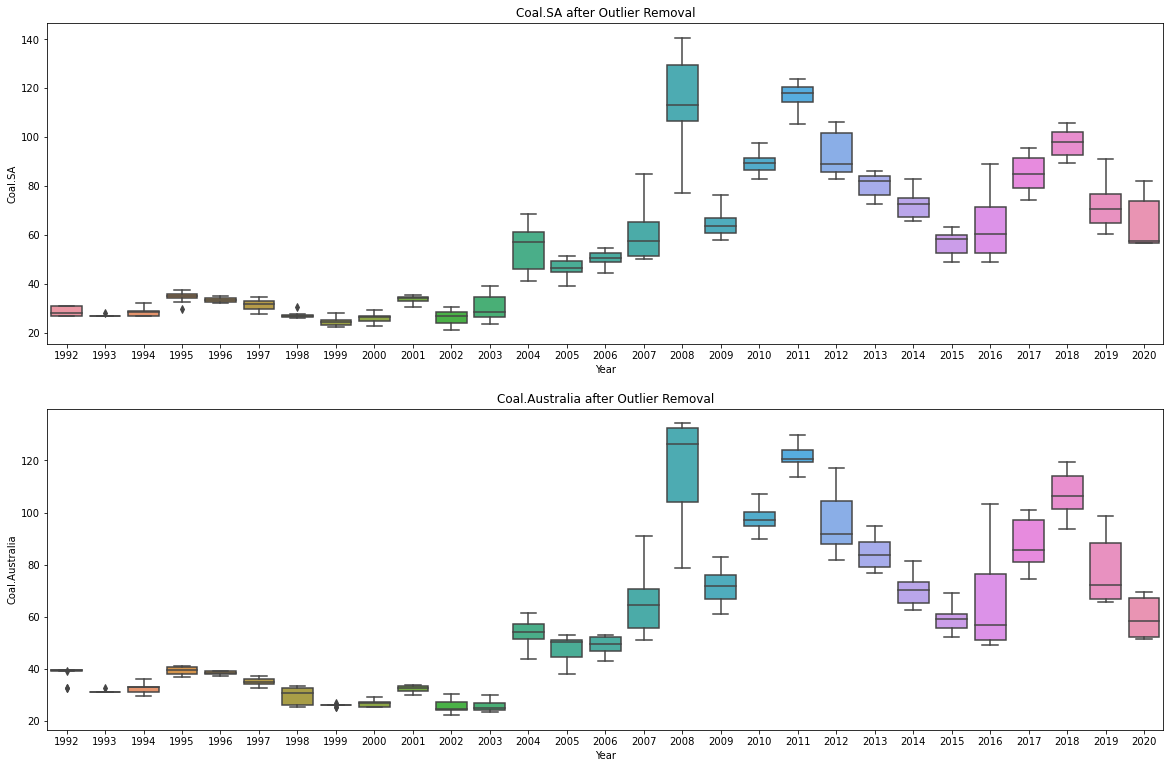

In [43]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='Coal.SA',ax=ax3[0]).set_title("Coal.SA after Outlier Removal")
sns.boxplot(data=df, x='Year', y='Coal.Australia',ax=ax3[1]).set_title("Coal.Australia after Outlier Removal")

In [44]:
#For Fuel.Index
years = [1993,1998,1997,2002,2003,2012,2010,2014]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Fuel.Index",year,"Year")
            if(df['Fuel.Index'][ind] > Upper_Whisker):
                df.replace(df['Fuel.Index'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Fuel.Index'][ind] < Lower_Whisker):
                df.replace(df['Fuel.Index'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 


In [45]:
#For Coal Producer Index
years = [1995,2001,1997,2005,2007,2008,2009,2013,2017,2019,2020]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Coal.Producer.Index",year,"Year")
            if(df['Coal.Producer.Index'][ind] > Upper_Whisker):
                df.replace(df['Coal.Producer.Index'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Coal.Producer.Index'][ind] < Lower_Whisker):
                df.replace(df['Coal.Producer.Index'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

Text(0.5, 1.0, 'Coal.Producer.Index after Outlier Removal')

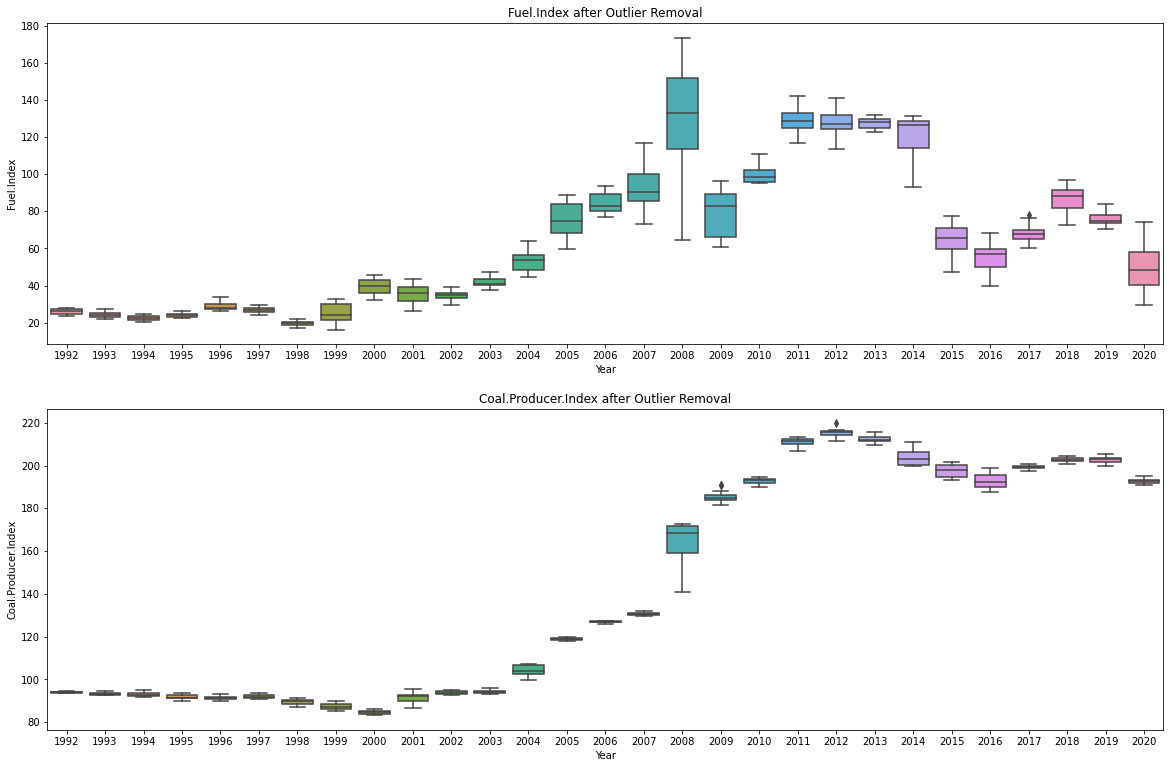

In [46]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='Fuel.Index',ax=ax3[0]).set_title("Fuel.Index after Outlier Removal")
sns.boxplot(data=df, x='Year', y='Coal.Producer.Index',ax=ax3[1]).set_title("Coal.Producer.Index after Outlier Removal")

In [47]:
#For IronOre
years = [1998,2016,2013,2019]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("IronOre",year,"Year")
            if(df['IronOre'][ind] > Upper_Whisker):
                df.replace(df['IronOre'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['IronOre'][ind] < Lower_Whisker):
                df.replace(df['IronOre'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

In [48]:
#For Crude.Oil.Index
years = [1997,1998,2001,2002,2008,2010,2014,2016,2013,2019]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("CrudeOil.Index",year,"Year")
            if(df['CrudeOil.Index'][ind] > Upper_Whisker):
                df.replace(df['CrudeOil.Index'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['CrudeOil.Index'][ind] < Lower_Whisker):
                df.replace(df['CrudeOil.Index'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

Text(0.5, 1.0, 'CrudeOil.Index after Outlier Removal')

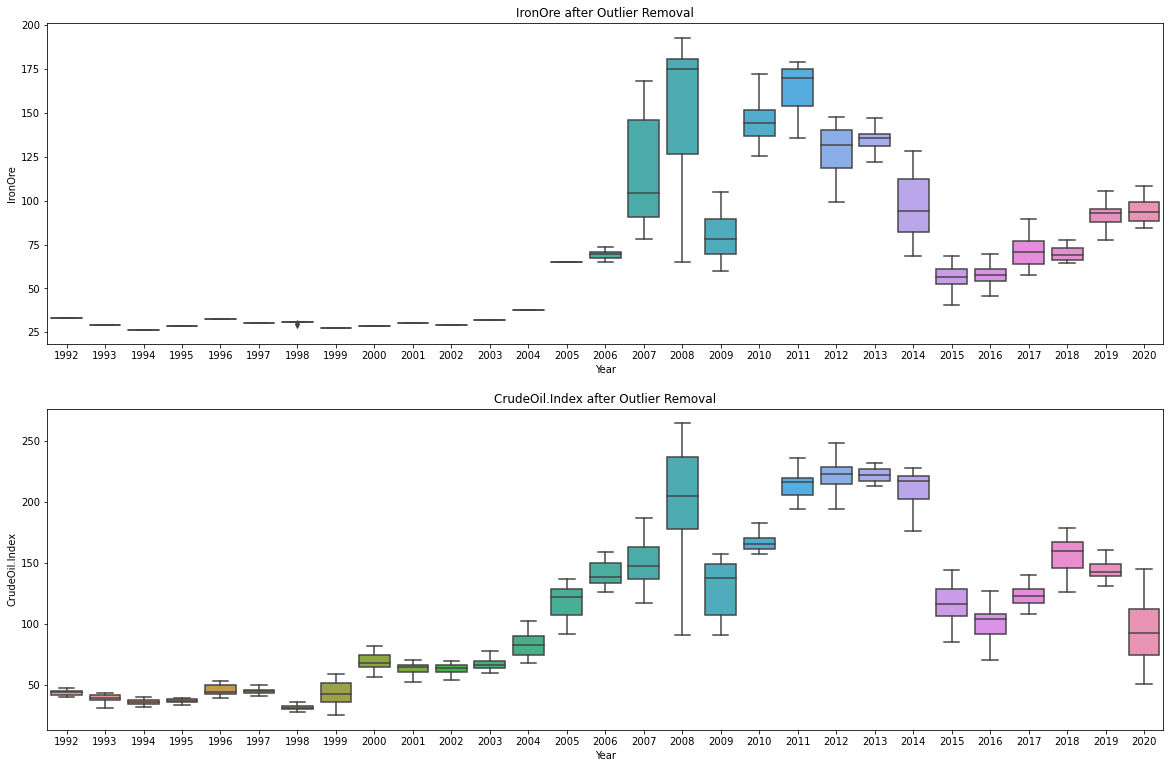

In [49]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='IronOre',ax=ax3[0]).set_title("IronOre after Outlier Removal")
sns.boxplot(data=df, x='Year', y='CrudeOil.Index',ax=ax3[1]).set_title("CrudeOil.Index after Outlier Removal")

In [50]:
#For Non-Fuel Index
years = [2003,2004,2005,2011]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("NonFuel.Index",year,"Year")
            if(df['NonFuel.Index'][ind] > Upper_Whisker):
                df.replace(df['NonFuel.Index'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['NonFuel.Index'][ind] < Lower_Whisker):
                df.replace(df['NonFuel.Index'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 


In [51]:
#For Commodity.Oil.Index
years = [1995,1996,2002,2013,2010,2014,2018]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Commodity.Index",year,"Year")
            if(df['Commodity.Index'][ind] > Upper_Whisker):
                df.replace(df['Commodity.Index'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Commodity.Index'][ind] < Lower_Whisker):
                df.replace(df['Commodity.Index'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

Text(0.5, 1.0, 'Commodity.Index after Outlier Removal')

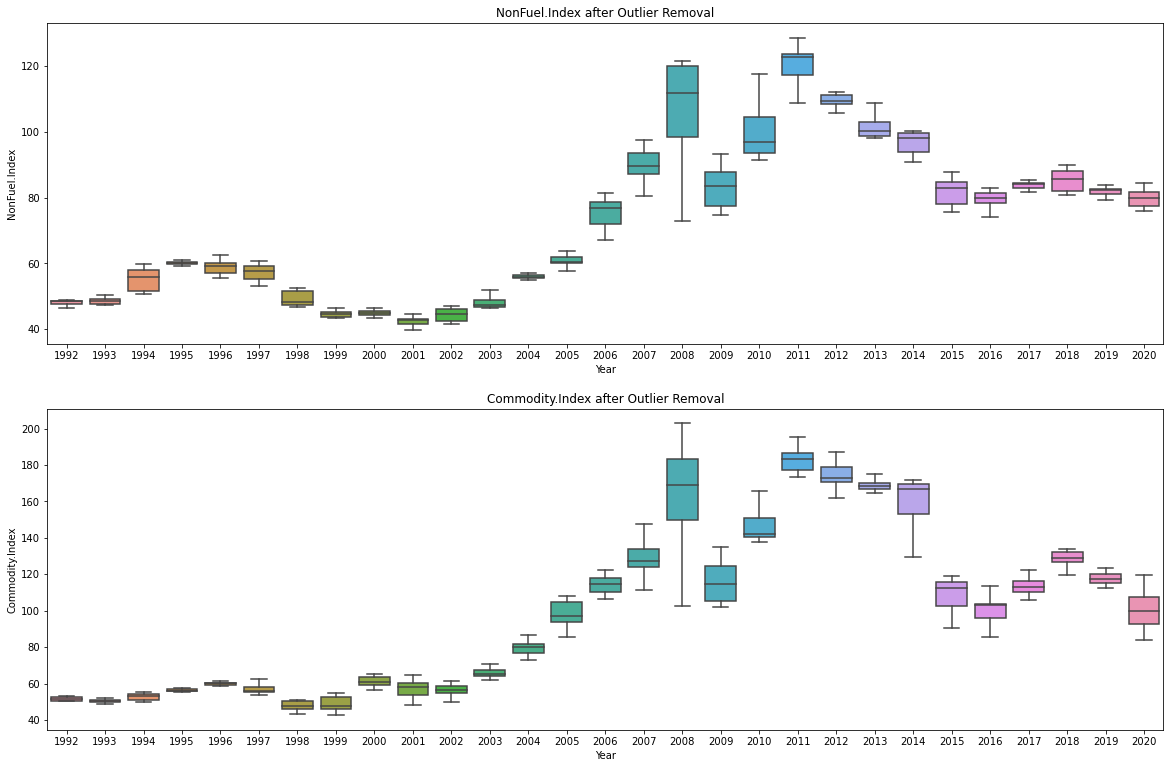

In [52]:
ffig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year', y='NonFuel.Index',ax=ax3[0]).set_title("NonFuel.Index after Outlier Removal")
sns.boxplot(data=df, x='Year', y='Commodity.Index',ax=ax3[1]).set_title("Commodity.Index after Outlier Removal")

In [53]:
#For CCI
years = [1995,1999,2000,2004,2009,2014,2016,2018]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("CCI",year,"Year")
            if(df['CCI'][ind] > Upper_Whisker):
                df.replace(df['CCI'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['CCI'][ind] < Lower_Whisker):
                df.replace(df['CCI'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 


In [54]:
#For Metal Index
years = [2003,2004,2005,2013,2016,1997]
for ind in df.index:
    for year in years:
        if (df['Year'][ind] == year): 
            Upper_Whisker,Lower_Whisker = calculate_whiskers("Metal.Index",year,"Year")
            if(df['Metal.Index'][ind] > Upper_Whisker):
                df.replace(df['Metal.Index'][ind],(Upper_Whisker-1),inplace=True)
            elif(df['Metal.Index'][ind] < Lower_Whisker):
                df.replace(df['Metal.Index'][ind],(Lower_Whisker+1),inplace=True)
            else:
                continue 

In [61]:
df=df.sort_index()

Text(0.5, 1.0, 'Metal.Index after Outlier Removal')

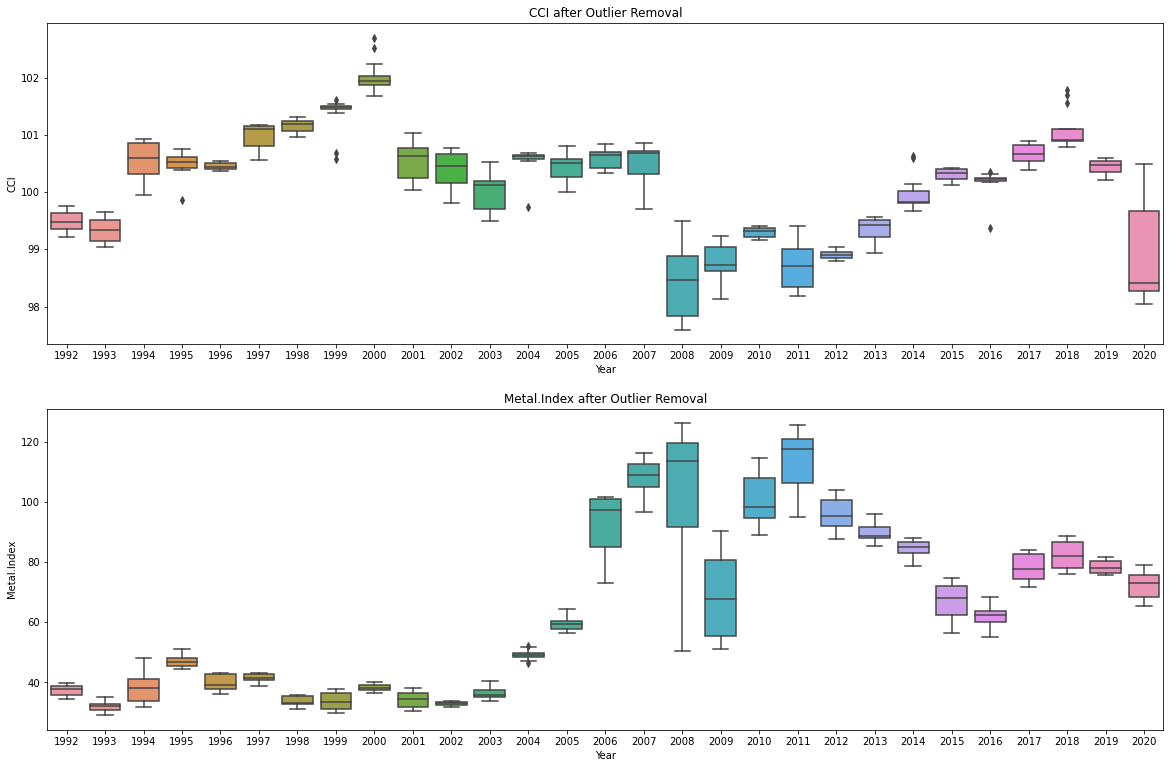

In [55]:
fig3,ax3 = plt.subplots(2,figsize=(20,13))
sns.boxplot(data=df, x='Year',ax=ax3[0],y='CCI').set_title("CCI after Outlier Removal")
sns.boxplot(data=df, x='Year',ax=ax3[1],y='Metal.Index').set_title("Metal.Index after Outlier Removal")

We handled outliers in years perspective as seen in the graphs. We believe the reason for the outliers is the economic crise in 2008. There was a sharp slowdown in demand,and with mining output remaining stubbornly high. Therefore, coal benchmarks fell down.

## Stationarity 

As mentioned in the trend section, we need to further check stationarity using these methods:

ADF plot: If most of the (95%) autocorrelation values are within the confidence interval, we can conclude that the series is stationary.

Dickey-Fuller Test: The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the test statistic is less than the critical value (0.05), we can say that time series is stationary.

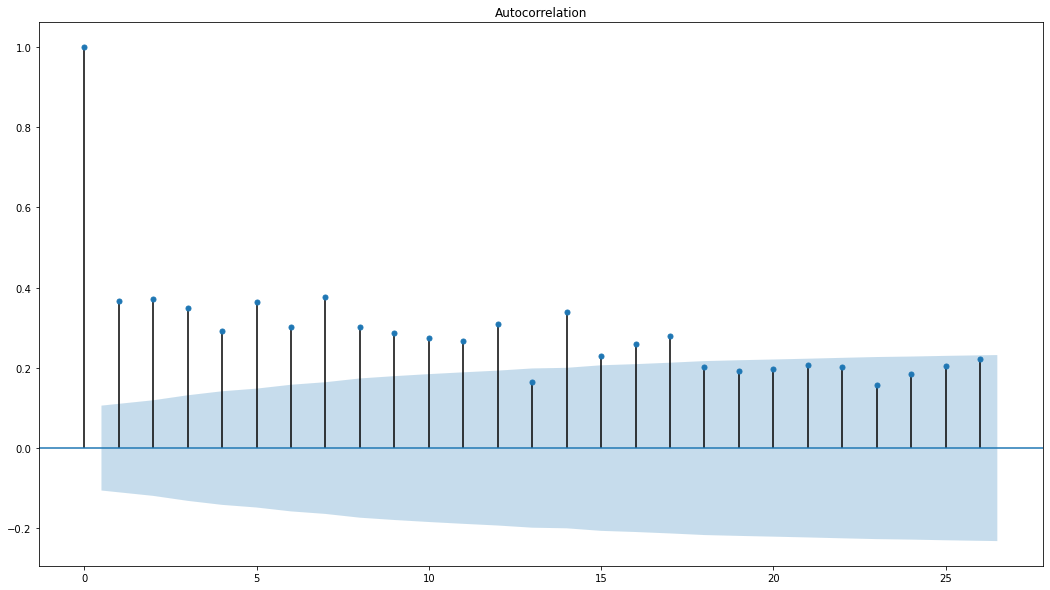

In [56]:
plot_acf(df["Coal.SA"]);

Looking at the ACF plot, since none of the lags are within the confidence interval, we can conclude that the Coal.SA series is non-stationary.

In [57]:
from statsmodels.tsa.stattools import adfuller
# check for stationarity
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [58]:
adf_test(df["Coal.SA"],title='')  

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.238759
p-value                   0.192480
# lags used              13.000000
# observations          329.000000
critical value (1%)      -3.450384
critical value (5%)      -2.870365
critical value (10%)     -2.571472
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [59]:
adf_test(df["Coal.SA"].apply(lambda x: np.log(x)).diff(periods=1), title='')     

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.672631e+00
p-value                 4.503251e-14
# lags used             1.200000e+01
# observations          3.290000e+02
critical value (1%)    -3.450384e+00
critical value (5%)    -2.870365e+00
critical value (10%)   -2.571472e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In order to make the series stationary, we are using differencing to trend effects from the original series.

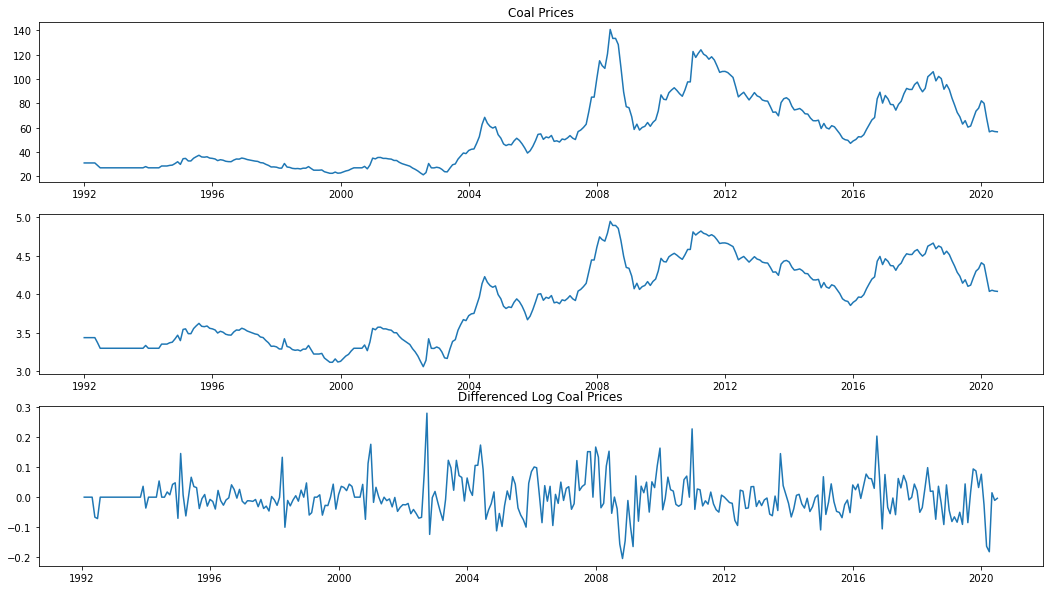

In [62]:
fig, ax = plt.subplots(3);
ax[0].plot(df["Coal.SA"]);
ax[0].set_title("Coal Prices")
ax[1].plot(np.log(df["Coal.SA"]))
ax[2].plot(df["Coal.SA"].apply(lambda x: np.log(x)).diff(periods=1));
ax[2].set_title("Differenced Log Coal Prices");

Looking at the time plots, the differenced series look a lot more stationary than the original series. We need to further inspect using ADF method as mentioned above.

# ARIMA

(p,d,q) is parameters of ARIMA model.

In order to choose p,d,q parameters we will use two different plots.

1) Autocorrelation Function (ACF): Measurement of the correlation between time series and lagged version of time series.

2) Partial Autocorrelation Function (PACF): This measures the correlation between the time series and lagged version of time series but after eliminating the variations already explained by the intervening comparisons.



In [63]:
ts=df["Coal.SA"].apply(lambda x: np.log(x)).diff(periods=1).dropna()

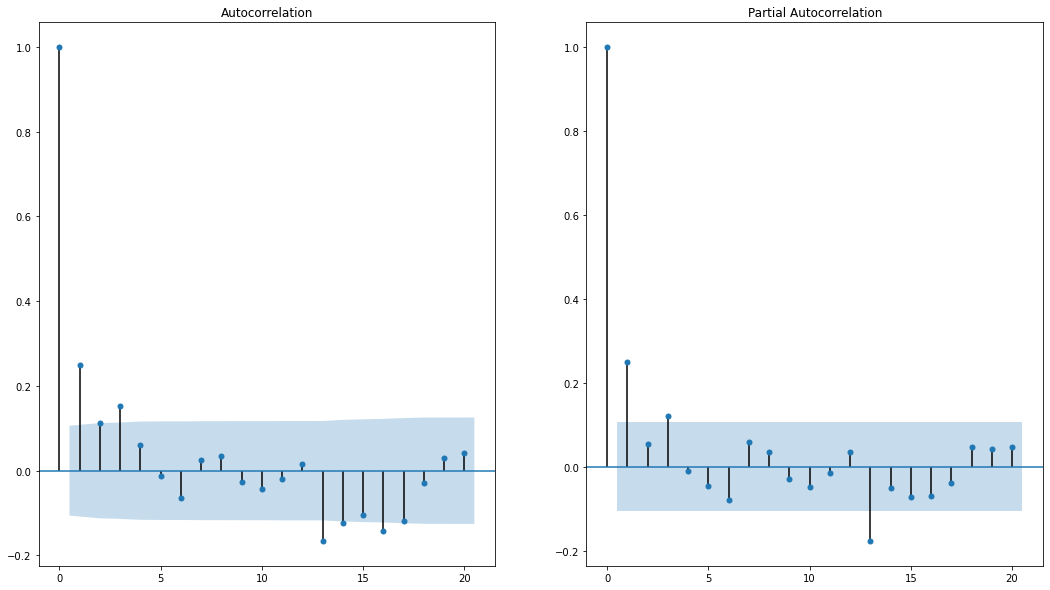

In [64]:
fig, ax = plt.subplots(1,2)
plot_acf(ts, lags=20, ax=ax[0]);
plot_pacf(ts, lags=20, ax=ax[1]);

Two dotted lines are the confidence interevals. We use these lines to determine the ‘p’ and ‘q’ values

The data may follow an ARIMA(p,d,0) model if the ACF and PACF plots of the differenced data show the following patterns:

    the ACF is exponentially decaying or sinusoidal;
    
    there is a significant spike at lag  p in the PACF, but none beyond lag p.

The data may follow an ARIMA(0, d, q) model if the ACF and PACF plots of the differenced data show the following patterns:

    the PACF is exponentially decaying or sinusoidal;
    
    there is a significant spike at lag  q in the ACF, but none beyond lag q.

Looking at the PACF plot, we can say that there is a significant spike at lag 1 and none beyond lag 1, therefore ARIMA(1,0,0) is a strong candidate. Of course, when we use the original series (not differenced), we need to use ARIMA(1,1,0) to account for differencing.

In [65]:
from pandas import datetime
import warnings
warnings.filterwarnings("ignore")
# fit model
model=sm.tsa.statespace.SARIMAX(df['Coal.SA'],order=(1, 1, 0),seasonal_order=(0,0,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# predict from and to these dates
start_index = datetime(2016, 1, 1)
end_index = datetime(2020, 7, 1)

results=model.fit()

<ipython-input-65-6b832b590816>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


                               SARIMAX Results                                
Dep. Variable:                Coal.SA   No. Observations:                  343
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -976.903
Date:                Sat, 29 May 2021   AIC                           1957.806
Time:                        23:35:39   BIC                           1965.476
Sample:                    01-01-1992   HQIC                          1960.862
                         - 07-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2795      0.027     10.308      0.000       0.226       0.333
sigma2        17.7213      0.679     26.117      0.000      16.391      19.051
Ljung-Box (Q):                       71.70   Jarque-

## Forecasting

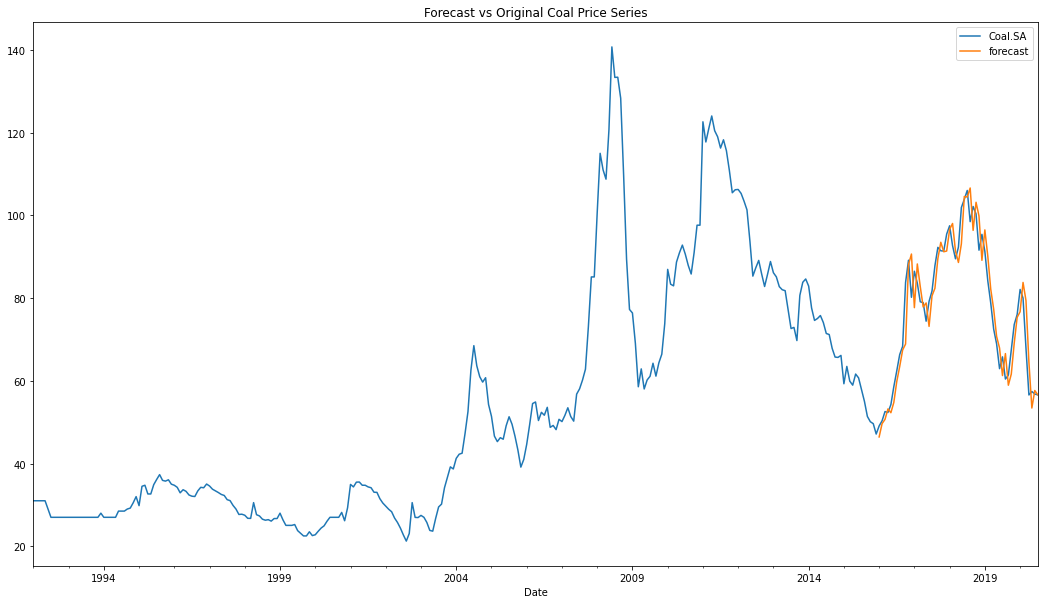

In [66]:
df['forecast']=results.predict(start=start_index, end=end_index)
df[['Coal.SA','forecast']].plot();
plt.title("Forecast vs Original Coal Price Series");

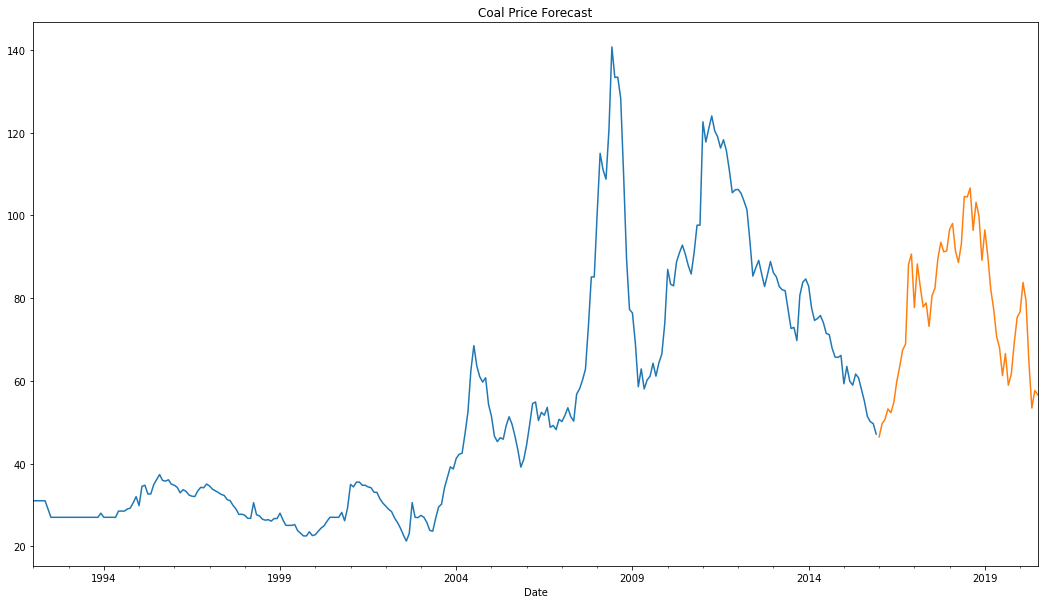

In [67]:
df["Coal.SA"][:-55].plot();
df['forecast'].plot();
plt.title("Coal Price Forecast");

In [68]:
from sklearn.metrics import mean_squared_error, r2_score
actual=df["Coal.SA"][-55:]
forecast=df["forecast"][-55:]
actual =actual.values
error = mean_squared_error(actual, forecast, squared = False)
#let's calculate the metric R^2 to compare all models
#import sklearn.metrics as sm
print("RMSE =",error)
print("R^2 score =", round(r2_score(actual, forecast), 2))
# if R^2 is nearly 1, it's the best case.

RMSE = 5.133192343961432
R^2 score = 0.9
